In [1]:
# Mixed new and old data

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
#from keras.utils.vis_utils import plot_model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import load_model
# Set the random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)




def build_unet(input_shape, seed_value=42):
    
    # Create separate input layers 
    input_low_geometry = Input(shape=input_shape, name='low_geometry_input')
   
    

    

    # Contracting path
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(input_low_geometry )
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv5)

    # Expanding path
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), padding='same')(conv9)

    # Velocity output layer
    velocity_outputs = Conv2D(1, 1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), name='velocity_output')(conv9)

    # Pressure output layer
    pressure_outputs = Conv2D(1, 1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), name='pressure_output')(conv9)

    model = Model(inputs=input_low_geometry, outputs=[pressure_outputs, velocity_outputs])
    return model

def boundary_loss(y_true, y_pred):
    # Extract velocity and pressure from predictions and true values
    velocity_pred = y_pred[0]
    pressure_pred = y_pred[1]
    velocity_true = y_true[0]
    pressure_true = y_true[1]
    
    # Compute max and min values for velocity and pressure
    velocity_pred_max = tf.reduce_max(velocity_pred)
    velocity_pred_min = tf.reduce_min(velocity_pred)
    velocity_true_max = tf.reduce_max(velocity_true)
    velocity_true_min = tf.reduce_min(velocity_true)
    
    pressure_pred_max = tf.reduce_max(pressure_pred)
    pressure_pred_min = tf.reduce_min(pressure_pred)
    pressure_true_max = tf.reduce_max(pressure_true)
    pressure_true_min = tf.reduce_min(pressure_true)
    
    # Compute residuals for max and min values
    velocity_residual = tf.square(velocity_pred_max - velocity_true_max) + tf.square(velocity_pred_min - velocity_true_min)
    pressure_residual = tf.square(pressure_pred_max - pressure_true_max) + tf.square(pressure_pred_min - pressure_true_min)
    
    # Total loss as the sum of residuals
    tloss = (velocity_residual + pressure_residual)/2
    
    return tloss








def physical_loss(y_true, y_pred):
    
    # Extract velocity and pressure from predictions and true values
    velocity_pred = y_pred[0]
    pressure_pred = y_pred[1]
    velocity_true = y_true[0]
    pressure_true = y_true[1]
    
    
    # Convert the numpy array to a TensorFlow tensor
    velocity_true = tf.convert_to_tensor(velocity_true, dtype=tf.float32)
    pressure_true = tf.convert_to_tensor(pressure_true, dtype=tf.float32)
    
    
    
    velocity_true = tf.expand_dims(velocity_true, axis=-1)
    pressure_true = tf.expand_dims(pressure_true, axis=-1)
    
    velocity_true = tf.expand_dims(velocity_true, axis=0)
    pressure_true = tf.expand_dims(pressure_true, axis=0)
    
    
    velocity_pred = tf.expand_dims(velocity_pred, axis=-1)
    pressure_pred = tf.expand_dims(pressure_pred, axis=-1)

    velocity_pred = tf.expand_dims(velocity_pred, axis=0)
    pressure_pred = tf.expand_dims(pressure_pred, axis=0)

    

    # Compute gradients
    velocity_gradients_pred = tf.image.image_gradients(velocity_pred)
    pressure_gradients_pred = tf.image.image_gradients(pressure_pred)
    velocity_gradients_true = tf.image.image_gradients(velocity_true)
    pressure_gradients_true = tf.image.image_gradients(pressure_true)

    # Compute divergence of velocity (for continuity equation)
    divergence_velocity_pred = velocity_gradients_pred[0] + velocity_gradients_pred[1]
    divergence_velocity_true = velocity_gradients_true[0] + velocity_gradients_true[1]
    
    divergence_pressure_pred = pressure_gradients_pred[0]+ pressure_gradients_pred[1]
    divergence_pressure_true = pressure_gradients_true[0] + pressure_gradients_true[1]


    # Compute the convective term (u · ∇)u for predicted and true velocity
    convective_term_pred = (
        velocity_pred[0] * velocity_gradients_pred[0] + 
        velocity_pred[0] * velocity_gradients_pred[1]
    )
    convective_term_true = (
        velocity_true[0] * velocity_gradients_true[0] + 
        velocity_true[0] * velocity_gradients_true[1]
    )

    # Compute the viscous term μ∇²u (Laplacian of velocity) for predicted and true velocity
    viscous_term_pred =  (
        tf.image.image_gradients(velocity_gradients_pred[0]) + 
        tf.image.image_gradients(velocity_gradients_pred[1])
    )
    viscous_term_true =  (
        tf.image.image_gradients(velocity_gradients_true[0]) + 
        tf.image.image_gradients(velocity_gradients_true[1])
    )

    # Compute the pressure gradient term ∇p for predicted and true pressure
    pressure_gradient_pred = tf.concat(pressure_gradients_pred, axis=-1)
    pressure_gradient_true = tf.concat(pressure_gradients_true, axis=-1)

    # Compute the momentum residual for predicted and true values
    momentum_residual_pred = (
        convective_term_pred - 
        pressure_gradient_pred + 
        viscous_term_pred
    )
    momentum_residual_true = (
        convective_term_true - 
        pressure_gradient_true + 
        viscous_term_true
    )
    
    
   
    

    # Compute the L2 norm of the momentum residual
    momentum_residual_norm = tf.reduce_mean(tf.square(momentum_residual_pred - momentum_residual_true))

    # Compute the L2 norm of the continuity residual
    continuity_residual_norm = tf.reduce_mean(tf.square(divergence_velocity_pred - divergence_velocity_true))

    # Total physical loss is the sum of momentum and continuity residuals
    physical_loss_value = 0.2*momentum_residual_norm +continuity_residual_norm

    return physical_loss_value

    
    



def total_loss(y_true, y_pred):
    # You can customize the weighting of the data loss and physical loss here
    weight_boundary_loss = 0.001
    weight_physical_loss = 0.999
    phy=physical_loss(y_true, y_pred)

    # Calculate the total loss as a combination of Boundary loss and physical loss
    total_loss = (weight_boundary_loss * boundary_loss(y_true, y_pred) )+(weight_physical_loss * phy )
    return total_loss
     




# Train the model with your dataset
import os
import numpy as np
from PIL import Image
from keras.callbacks import ModelCheckpoint







hv_folder = 'High/HVV'
hp_folder = 'High/HPP'
lg_folder = 'LG-3C2'



# Get the list of file names in each folder

hv_files = [f for f in os.listdir(hv_folder) if f != ".ipynb_checkpoints"]
hp_files = [f for f in os.listdir(hp_folder) if f != ".ipynb_checkpoints"]
lg_files = [f for f in os.listdir(lg_folder) if f != ".ipynb_checkpoints"]

# Sort the file names to ensure the order is consistent

hv_files.sort()
hp_files.sort()
lg_files.sort()


# Set the input shape
input_shape = (256, 256, 3)  # Update to 3 channels for color images

# Create empty lists to store the data

X_lg = []
Y_hv = []
Y_hp = []

# Read the data from the folders
for hv_file,hp_file,lg_file in zip( hv_files,hp_files,lg_files):
    try:
        
        
        # Read the HFV
        hv_image = np.load(os.path.join(hv_folder, hv_file))  # Convert to RGB
        Y_hv.append(np.array(hv_image))

    
    
        # Read the channel geometry image
        lg_image = Image.open(os.path.join(lg_folder, lg_file)).convert('RGB')  # Convert to RGB
        lg_image = lg_image.resize(input_shape[:2])  # Resize the image
        X_lg.append(np.array(lg_image))
    
        # Read the HFP
        hp_image = np.load(os.path.join(hp_folder, hp_file))  # Convert to RGB
        Y_hp.append(np.array(hp_image))
    except:
        print('')

# Convert the lists to arrays
X_lg = np.array(X_lg) / 255.0  # Normalize the channel geometry images
Y_hv = np.array(Y_hv)
Y_hp = np.array(Y_hp)

Y_hpt=(Y_hp-np.min(Y_hp))/(np.max(Y_hp)-np.min(Y_hp))






# Build the U-Net model
model = build_unet(input_shape)


optim = Adam(learning_rate=0.00001)
# Compile the model with the desired loss functions
model.compile(optimizer=optim,
              loss=[total_loss,total_loss])
# Set up checkpoints to save the best model during training
checkpoint_path = 'Saved_Models_Temp/Micro-Unet-Zero-new.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Train the model
epochs = 2400
batch_size = 16
print('start fitting')
model.fit(X_lg, [Y_hpt, Y_hv],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[checkpoint])





2025-03-17 05:37:46.661008: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-03-17 05:37:46.661034: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2025-03-17 05:37:46.661038: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2025-03-17 05:37:46.661068: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-17 05:37:46.661084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


start fitting
Epoch 1/2400


2025-03-17 05:37:49.308046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - ETA: 0s - loss: 0.0011 - pressure_output_loss: 4.6119e-04 - velocity_output_loss: 5.9889e-04

2025-03-17 05:39:03.272921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.00065, saving model to Saved_Models/Micro-Unet-Zero-new.h5


/Users/trina-mrd-lab2/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


142/142 [==============================] - 81s 560ms/step - loss: 0.0011 - pressure_output_loss: 4.6119e-04 - velocity_output_loss: 5.9889e-04 - val_loss: 6.4536e-04 - val_pressure_output_loss: 2.4497e-04 - val_velocity_output_loss: 4.0039e-04
Epoch 2/2400
142/142 [==============================] - ETA: 0s - loss: 8.8032e-04 - pressure_output_loss: 3.6786e-04 - velocity_output_loss: 5.1246e-04
Epoch 2: val_loss improved from 0.00065 to 0.00059, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 78s 550ms/step - loss: 8.8032e-04 - pressure_output_loss: 3.6786e-04 - velocity_output_loss: 5.1246e-04 - val_loss: 5.8560e-04 - val_pressure_output_loss: 2.2414e-04 - val_velocity_output_loss: 3.6146e-04
Epoch 3/2400
142/142 [==============================] - ETA: 0s - loss: 7.6675e-04 - pressure_output_loss: 3.1424e-04 - velocity_output_loss: 4.5251e-04
Epoch 3: val_loss improved from 0.00059 to 0.00053, saving model to Saved_Models/Micro-Unet-Zero-n

Epoch 18/2400
142/142 [==============================] - ETA: 0s - loss: 3.6121e-04 - pressure_output_loss: 7.8370e-05 - velocity_output_loss: 2.8284e-04
Epoch 18: val_loss improved from 0.00011 to 0.00010, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 81s 568ms/step - loss: 3.6121e-04 - pressure_output_loss: 7.8370e-05 - velocity_output_loss: 2.8284e-04 - val_loss: 1.0394e-04 - val_pressure_output_loss: 3.5504e-05 - val_velocity_output_loss: 6.8438e-05
Epoch 19/2400
142/142 [==============================] - ETA: 0s - loss: 3.5910e-04 - pressure_output_loss: 7.7509e-05 - velocity_output_loss: 2.8159e-04
Epoch 19: val_loss did not improve from 0.00010
142/142 [==============================] - 81s 571ms/step - loss: 3.5910e-04 - pressure_output_loss: 7.7509e-05 - velocity_output_loss: 2.8159e-04 - val_loss: 1.0434e-04 - val_pressure_output_loss: 3.6753e-05 - val_velocity_output_loss: 6.7588e-05
Epoch 20/2400
142/142 [====================

Epoch 53/2400
142/142 [==============================] - ETA: 0s - loss: 2.9154e-04 - pressure_output_loss: 3.0381e-05 - velocity_output_loss: 2.6116e-04
Epoch 53: val_loss improved from 0.00008 to 0.00007, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 79s 559ms/step - loss: 2.9154e-04 - pressure_output_loss: 3.0381e-05 - velocity_output_loss: 2.6116e-04 - val_loss: 7.4321e-05 - val_pressure_output_loss: 2.0709e-05 - val_velocity_output_loss: 5.3612e-05
Epoch 54/2400
142/142 [==============================] - ETA: 0s - loss: 3.2626e-04 - pressure_output_loss: 3.7671e-05 - velocity_output_loss: 2.8859e-04
Epoch 54: val_loss improved from 0.00007 to 0.00007, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 79s 559ms/step - loss: 3.2626e-04 - pressure_output_loss: 3.7671e-05 - velocity_output_loss: 2.8859e-04 - val_loss: 7.3361e-05 - val_pressure_output_loss: 1.9907e-05 - val_velocity_output_los

142/142 [==============================] - 80s 562ms/step - loss: 3.0645e-04 - pressure_output_loss: 2.9484e-05 - velocity_output_loss: 2.7696e-04 - val_loss: 7.1547e-05 - val_pressure_output_loss: 1.5811e-05 - val_velocity_output_loss: 5.5736e-05
Epoch 71/2400
142/142 [==============================] - ETA: 0s - loss: 2.8132e-04 - pressure_output_loss: 3.3191e-05 - velocity_output_loss: 2.4813e-04
Epoch 71: val_loss did not improve from 0.00007
142/142 [==============================] - 80s 562ms/step - loss: 2.8132e-04 - pressure_output_loss: 3.3191e-05 - velocity_output_loss: 2.4813e-04 - val_loss: 7.1593e-05 - val_pressure_output_loss: 1.5977e-05 - val_velocity_output_loss: 5.5615e-05
Epoch 72/2400
142/142 [==============================] - ETA: 0s - loss: 3.1336e-04 - pressure_output_loss: 3.1685e-05 - velocity_output_loss: 2.8168e-04
Epoch 72: val_loss did not improve from 0.00007
142/142 [==============================] - 80s 561ms/step - loss: 3.1336e-04 - pressure_output_loss:

Epoch 89/2400
142/142 [==============================] - ETA: 0s - loss: 2.9581e-04 - pressure_output_loss: 3.1897e-05 - velocity_output_loss: 2.6391e-04
Epoch 89: val_loss did not improve from 0.00007
142/142 [==============================] - 80s 564ms/step - loss: 2.9581e-04 - pressure_output_loss: 3.1897e-05 - velocity_output_loss: 2.6391e-04 - val_loss: 6.9373e-05 - val_pressure_output_loss: 1.2897e-05 - val_velocity_output_loss: 5.6476e-05
Epoch 90/2400
142/142 [==============================] - ETA: 0s - loss: 5.4918e-04 - pressure_output_loss: 2.4736e-04 - velocity_output_loss: 3.0182e-04
Epoch 90: val_loss did not improve from 0.00007
142/142 [==============================] - 80s 563ms/step - loss: 5.4918e-04 - pressure_output_loss: 2.4736e-04 - velocity_output_loss: 3.0182e-04 - val_loss: 9.1007e-05 - val_pressure_output_loss: 2.7927e-05 - val_velocity_output_loss: 6.3080e-05
Epoch 91/2400
142/142 [==============================] - ETA: 0s - loss: 3.1888e-04 - pressure_outpu

Epoch 107/2400
142/142 [==============================] - ETA: 0s - loss: 5.0954e-04 - pressure_output_loss: 2.2725e-04 - velocity_output_loss: 2.8229e-04
Epoch 107: val_loss did not improve from 0.00007
142/142 [==============================] - 81s 570ms/step - loss: 5.0954e-04 - pressure_output_loss: 2.2725e-04 - velocity_output_loss: 2.8229e-04 - val_loss: 7.0185e-05 - val_pressure_output_loss: 1.3354e-05 - val_velocity_output_loss: 5.6831e-05
Epoch 108/2400
142/142 [==============================] - ETA: 0s - loss: 3.1710e-04 - pressure_output_loss: 3.0546e-05 - velocity_output_loss: 2.8656e-04
Epoch 108: val_loss did not improve from 0.00007
142/142 [==============================] - 81s 567ms/step - loss: 3.1710e-04 - pressure_output_loss: 3.0546e-05 - velocity_output_loss: 2.8656e-04 - val_loss: 7.1341e-05 - val_pressure_output_loss: 1.3080e-05 - val_velocity_output_loss: 5.8260e-05
Epoch 109/2400
142/142 [==============================] - ETA: 0s - loss: 2.8529e-04 - pressure_

Epoch 125/2400
142/142 [==============================] - ETA: 0s - loss: 3.1076e-04 - pressure_output_loss: 4.3800e-05 - velocity_output_loss: 2.6696e-04
Epoch 125: val_loss did not improve from 0.00007
142/142 [==============================] - 82s 579ms/step - loss: 3.1076e-04 - pressure_output_loss: 4.3800e-05 - velocity_output_loss: 2.6696e-04 - val_loss: 6.6131e-05 - val_pressure_output_loss: 1.0714e-05 - val_velocity_output_loss: 5.5416e-05
Epoch 126/2400
142/142 [==============================] - ETA: 0s - loss: 3.3710e-04 - pressure_output_loss: 5.2920e-05 - velocity_output_loss: 2.8418e-04
Epoch 126: val_loss did not improve from 0.00007
142/142 [==============================] - 81s 573ms/step - loss: 3.3710e-04 - pressure_output_loss: 5.2920e-05 - velocity_output_loss: 2.8418e-04 - val_loss: 6.7986e-05 - val_pressure_output_loss: 1.0535e-05 - val_velocity_output_loss: 5.7451e-05
Epoch 127/2400
142/142 [==============================] - ETA: 0s - loss: 3.3834e-04 - pressure_

142/142 [==============================] - ETA: 0s - loss: 3.0566e-04 - pressure_output_loss: 3.2168e-05 - velocity_output_loss: 2.7349e-04
Epoch 159: val_loss improved from 0.00005 to 0.00005, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 82s 577ms/step - loss: 3.0566e-04 - pressure_output_loss: 3.2168e-05 - velocity_output_loss: 2.7349e-04 - val_loss: 4.8063e-05 - val_pressure_output_loss: 8.5479e-06 - val_velocity_output_loss: 3.9515e-05
Epoch 160/2400
142/142 [==============================] - ETA: 0s - loss: 2.6127e-04 - pressure_output_loss: 2.9179e-05 - velocity_output_loss: 2.3209e-04
Epoch 160: val_loss improved from 0.00005 to 0.00005, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 83s 586ms/step - loss: 2.6127e-04 - pressure_output_loss: 2.9179e-05 - velocity_output_loss: 2.3209e-04 - val_loss: 4.7426e-05 - val_pressure_output_loss: 8.4408e-06 - val_velocity_output_loss: 3.8985e-

142/142 [==============================] - 83s 587ms/step - loss: 2.8181e-04 - pressure_output_loss: 2.4189e-05 - velocity_output_loss: 2.5762e-04 - val_loss: 4.6455e-05 - val_pressure_output_loss: 7.8688e-06 - val_velocity_output_loss: 3.8586e-05
Epoch 177/2400
142/142 [==============================] - ETA: 0s - loss: 2.6832e-04 - pressure_output_loss: 3.3089e-05 - velocity_output_loss: 2.3523e-04
Epoch 177: val_loss improved from 0.00005 to 0.00005, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 84s 592ms/step - loss: 2.6832e-04 - pressure_output_loss: 3.3089e-05 - velocity_output_loss: 2.3523e-04 - val_loss: 4.6233e-05 - val_pressure_output_loss: 7.7607e-06 - val_velocity_output_loss: 3.8472e-05
Epoch 178/2400
142/142 [==============================] - ETA: 0s - loss: 2.8682e-04 - pressure_output_loss: 3.4378e-05 - velocity_output_loss: 2.5244e-04
Epoch 178: val_loss did not improve from 0.00005
142/142 [==============================

Epoch 194/2400
142/142 [==============================] - ETA: 0s - loss: 2.6923e-04 - pressure_output_loss: 2.4768e-05 - velocity_output_loss: 2.4447e-04
Epoch 194: val_loss improved from 0.00005 to 0.00005, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 82s 579ms/step - loss: 2.6923e-04 - pressure_output_loss: 2.4768e-05 - velocity_output_loss: 2.4447e-04 - val_loss: 4.5185e-05 - val_pressure_output_loss: 7.3696e-06 - val_velocity_output_loss: 3.7815e-05
Epoch 195/2400
142/142 [==============================] - ETA: 0s - loss: 2.9562e-04 - pressure_output_loss: 3.6349e-05 - velocity_output_loss: 2.5927e-04
Epoch 195: val_loss did not improve from 0.00005
142/142 [==============================] - 82s 576ms/step - loss: 2.9562e-04 - pressure_output_loss: 3.6349e-05 - velocity_output_loss: 2.5927e-04 - val_loss: 4.5727e-05 - val_pressure_output_loss: 7.6240e-06 - val_velocity_output_loss: 3.8103e-05
Epoch 196/2400
142/142 [===============

Epoch 212/2400
142/142 [==============================] - ETA: 0s - loss: 2.8289e-04 - pressure_output_loss: 2.8388e-05 - velocity_output_loss: 2.5450e-04
Epoch 212: val_loss did not improve from 0.00004
142/142 [==============================] - 80s 567ms/step - loss: 2.8289e-04 - pressure_output_loss: 2.8388e-05 - velocity_output_loss: 2.5450e-04 - val_loss: 4.5860e-05 - val_pressure_output_loss: 7.7618e-06 - val_velocity_output_loss: 3.8098e-05
Epoch 213/2400
142/142 [==============================] - ETA: 0s - loss: 5.0183e-04 - pressure_output_loss: 2.2109e-04 - velocity_output_loss: 2.8074e-04
Epoch 213: val_loss did not improve from 0.00004
142/142 [==============================] - 80s 566ms/step - loss: 5.0183e-04 - pressure_output_loss: 2.2109e-04 - velocity_output_loss: 2.8074e-04 - val_loss: 8.7036e-05 - val_pressure_output_loss: 3.2616e-05 - val_velocity_output_loss: 5.4419e-05
Epoch 214/2400
142/142 [==============================] - ETA: 0s - loss: 2.9362e-04 - pressure_

Epoch 230/2400
142/142 [==============================] - ETA: 0s - loss: 2.6806e-04 - pressure_output_loss: 2.7502e-05 - velocity_output_loss: 2.4056e-04
Epoch 230: val_loss did not improve from 0.00004
142/142 [==============================] - 81s 573ms/step - loss: 2.6806e-04 - pressure_output_loss: 2.7502e-05 - velocity_output_loss: 2.4056e-04 - val_loss: 4.5479e-05 - val_pressure_output_loss: 7.7834e-06 - val_velocity_output_loss: 3.7696e-05
Epoch 231/2400
142/142 [==============================] - ETA: 0s - loss: 2.7962e-04 - pressure_output_loss: 2.7545e-05 - velocity_output_loss: 2.5207e-04
Epoch 231: val_loss did not improve from 0.00004
142/142 [==============================] - 82s 576ms/step - loss: 2.7962e-04 - pressure_output_loss: 2.7545e-05 - velocity_output_loss: 2.5207e-04 - val_loss: 4.6811e-05 - val_pressure_output_loss: 8.3779e-06 - val_velocity_output_loss: 3.8433e-05
Epoch 232/2400
142/142 [==============================] - ETA: 0s - loss: 2.5091e-04 - pressure_

Epoch 248/2400
142/142 [==============================] - ETA: 0s - loss: 2.8128e-04 - pressure_output_loss: 2.6289e-05 - velocity_output_loss: 2.5499e-04
Epoch 248: val_loss did not improve from 0.00004
142/142 [==============================] - 80s 565ms/step - loss: 2.8128e-04 - pressure_output_loss: 2.6289e-05 - velocity_output_loss: 2.5499e-04 - val_loss: 4.4694e-05 - val_pressure_output_loss: 7.2701e-06 - val_velocity_output_loss: 3.7424e-05
Epoch 249/2400
142/142 [==============================] - ETA: 0s - loss: 2.9135e-04 - pressure_output_loss: 3.0784e-05 - velocity_output_loss: 2.6057e-04
Epoch 249: val_loss did not improve from 0.00004
142/142 [==============================] - 80s 567ms/step - loss: 2.9135e-04 - pressure_output_loss: 3.0784e-05 - velocity_output_loss: 2.6057e-04 - val_loss: 4.4577e-05 - val_pressure_output_loss: 7.3419e-06 - val_velocity_output_loss: 3.7235e-05
Epoch 250/2400
142/142 [==============================] - ETA: 0s - loss: 2.6193e-04 - pressure_

142/142 [==============================] - 81s 567ms/step - loss: 2.5465e-04 - pressure_output_loss: 2.7063e-05 - velocity_output_loss: 2.2759e-04 - val_loss: 4.5904e-05 - val_pressure_output_loss: 8.2981e-06 - val_velocity_output_loss: 3.7606e-05
Epoch 266/2400
142/142 [==============================] - ETA: 0s - loss: 2.7044e-04 - pressure_output_loss: 2.6051e-05 - velocity_output_loss: 2.4439e-04
Epoch 266: val_loss did not improve from 0.00004
142/142 [==============================] - 81s 567ms/step - loss: 2.7044e-04 - pressure_output_loss: 2.6051e-05 - velocity_output_loss: 2.4439e-04 - val_loss: 4.6110e-05 - val_pressure_output_loss: 8.8362e-06 - val_velocity_output_loss: 3.7273e-05
Epoch 267/2400
142/142 [==============================] - ETA: 0s - loss: 3.0899e-04 - pressure_output_loss: 3.0523e-05 - velocity_output_loss: 2.7847e-04
Epoch 267: val_loss did not improve from 0.00004
142/142 [==============================] - 80s 565ms/step - loss: 3.0899e-04 - pressure_output_l

142/142 [==============================] - 86s 604ms/step - loss: 2.6396e-04 - pressure_output_loss: 3.2733e-05 - velocity_output_loss: 2.3123e-04 - val_loss: 4.4017e-05 - val_pressure_output_loss: 8.0290e-06 - val_velocity_output_loss: 3.5988e-05
Epoch 284/2400
142/142 [==============================] - ETA: 0s - loss: 2.4294e-04 - pressure_output_loss: 2.6443e-05 - velocity_output_loss: 2.1650e-04
Epoch 284: val_loss did not improve from 0.00004
142/142 [==============================] - 85s 599ms/step - loss: 2.4294e-04 - pressure_output_loss: 2.6443e-05 - velocity_output_loss: 2.1650e-04 - val_loss: 4.4677e-05 - val_pressure_output_loss: 8.5056e-06 - val_velocity_output_loss: 3.6172e-05
Epoch 285/2400
142/142 [==============================] - ETA: 0s - loss: 3.3480e-04 - pressure_output_loss: 6.9999e-05 - velocity_output_loss: 2.6480e-04
Epoch 285: val_loss did not improve from 0.00004
142/142 [==============================] - 84s 593ms/step - loss: 3.3480e-04 - pressure_output_l

142/142 [==============================] - 80s 565ms/step - loss: 2.2635e-04 - pressure_output_loss: 2.6720e-05 - velocity_output_loss: 1.9963e-04 - val_loss: 3.8729e-05 - val_pressure_output_loss: 8.3045e-06 - val_velocity_output_loss: 3.0425e-05
Epoch 319/2400
142/142 [==============================] - ETA: 0s - loss: 4.2785e-04 - pressure_output_loss: 2.0711e-04 - velocity_output_loss: 2.2074e-04
Epoch 319: val_loss did not improve from 0.00004
142/142 [==============================] - 80s 566ms/step - loss: 4.2785e-04 - pressure_output_loss: 2.0711e-04 - velocity_output_loss: 2.2074e-04 - val_loss: 9.2546e-05 - val_pressure_output_loss: 4.3612e-05 - val_velocity_output_loss: 4.8934e-05
Epoch 320/2400
142/142 [==============================] - ETA: 0s - loss: 2.8229e-04 - pressure_output_loss: 3.9892e-05 - velocity_output_loss: 2.4239e-04
Epoch 320: val_loss did not improve from 0.00004
142/142 [==============================] - 82s 575ms/step - loss: 2.8229e-04 - pressure_output_l

Epoch 354/2400
142/142 [==============================] - ETA: 0s - loss: 1.8608e-04 - pressure_output_loss: 2.3884e-05 - velocity_output_loss: 1.6220e-04
Epoch 354: val_loss did not improve from 0.00003
142/142 [==============================] - 80s 566ms/step - loss: 1.8608e-04 - pressure_output_loss: 2.3884e-05 - velocity_output_loss: 1.6220e-04 - val_loss: 3.2730e-05 - val_pressure_output_loss: 7.9333e-06 - val_velocity_output_loss: 2.4797e-05
Epoch 355/2400
142/142 [==============================] - ETA: 0s - loss: 2.0580e-04 - pressure_output_loss: 2.6191e-05 - velocity_output_loss: 1.7961e-04
Epoch 355: val_loss did not improve from 0.00003
142/142 [==============================] - 80s 566ms/step - loss: 2.0580e-04 - pressure_output_loss: 2.6191e-05 - velocity_output_loss: 1.7961e-04 - val_loss: 3.4740e-05 - val_pressure_output_loss: 8.2209e-06 - val_velocity_output_loss: 2.6519e-05
Epoch 356/2400
142/142 [==============================] - ETA: 0s - loss: 1.9404e-04 - pressure_

Epoch 372/2400
142/142 [==============================] - ETA: 0s - loss: 1.8503e-04 - pressure_output_loss: 2.6742e-05 - velocity_output_loss: 1.5829e-04
Epoch 372: val_loss improved from 0.00003 to 0.00003, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 84s 592ms/step - loss: 1.8503e-04 - pressure_output_loss: 2.6742e-05 - velocity_output_loss: 1.5829e-04 - val_loss: 3.0038e-05 - val_pressure_output_loss: 7.6993e-06 - val_velocity_output_loss: 2.2339e-05
Epoch 373/2400
142/142 [==============================] - ETA: 0s - loss: 1.8716e-04 - pressure_output_loss: 2.8347e-05 - velocity_output_loss: 1.5881e-04
Epoch 373: val_loss did not improve from 0.00003
142/142 [==============================] - 83s 586ms/step - loss: 1.8716e-04 - pressure_output_loss: 2.8347e-05 - velocity_output_loss: 1.5881e-04 - val_loss: 3.2471e-05 - val_pressure_output_loss: 8.3273e-06 - val_velocity_output_loss: 2.4144e-05
Epoch 374/2400
142/142 [===============

142/142 [==============================] - 81s 572ms/step - loss: 3.4153e-04 - pressure_output_loss: 1.6511e-04 - velocity_output_loss: 1.7642e-04 - val_loss: 3.1011e-05 - val_pressure_output_loss: 8.6445e-06 - val_velocity_output_loss: 2.2367e-05
Epoch 390/2400
142/142 [==============================] - ETA: 0s - loss: 1.7474e-04 - pressure_output_loss: 2.5456e-05 - velocity_output_loss: 1.4928e-04
Epoch 390: val_loss did not improve from 0.00003
142/142 [==============================] - 80s 567ms/step - loss: 1.7474e-04 - pressure_output_loss: 2.5456e-05 - velocity_output_loss: 1.4928e-04 - val_loss: 2.9193e-05 - val_pressure_output_loss: 8.7077e-06 - val_velocity_output_loss: 2.0485e-05
Epoch 391/2400
142/142 [==============================] - ETA: 0s - loss: 1.7329e-04 - pressure_output_loss: 2.9192e-05 - velocity_output_loss: 1.4410e-04
Epoch 391: val_loss did not improve from 0.00003
142/142 [==============================] - 80s 566ms/step - loss: 1.7329e-04 - pressure_output_l

142/142 [==============================] - 81s 568ms/step - loss: 1.5654e-04 - pressure_output_loss: 2.1441e-05 - velocity_output_loss: 1.3510e-04 - val_loss: 2.8046e-05 - val_pressure_output_loss: 7.5661e-06 - val_velocity_output_loss: 2.0480e-05
Epoch 408/2400
142/142 [==============================] - ETA: 0s - loss: 1.6192e-04 - pressure_output_loss: 2.3511e-05 - velocity_output_loss: 1.3841e-04
Epoch 408: val_loss did not improve from 0.00003
142/142 [==============================] - 80s 565ms/step - loss: 1.6192e-04 - pressure_output_loss: 2.3511e-05 - velocity_output_loss: 1.3841e-04 - val_loss: 2.9026e-05 - val_pressure_output_loss: 7.6579e-06 - val_velocity_output_loss: 2.1368e-05
Epoch 409/2400
142/142 [==============================] - ETA: 0s - loss: 1.5206e-04 - pressure_output_loss: 2.5133e-05 - velocity_output_loss: 1.2693e-04
Epoch 409: val_loss did not improve from 0.00003
142/142 [==============================] - 80s 565ms/step - loss: 1.5206e-04 - pressure_output_l

142/142 [==============================] - 81s 573ms/step - loss: 1.6212e-04 - pressure_output_loss: 2.6796e-05 - velocity_output_loss: 1.3532e-04 - val_loss: 2.7128e-05 - val_pressure_output_loss: 7.3414e-06 - val_velocity_output_loss: 1.9786e-05
Epoch 426/2400
142/142 [==============================] - ETA: 0s - loss: 1.6338e-04 - pressure_output_loss: 2.1532e-05 - velocity_output_loss: 1.4185e-04
Epoch 426: val_loss did not improve from 0.00003
142/142 [==============================] - 81s 568ms/step - loss: 1.6338e-04 - pressure_output_loss: 2.1532e-05 - velocity_output_loss: 1.4185e-04 - val_loss: 2.6975e-05 - val_pressure_output_loss: 7.3457e-06 - val_velocity_output_loss: 1.9629e-05
Epoch 427/2400
142/142 [==============================] - ETA: 0s - loss: 1.5975e-04 - pressure_output_loss: 2.1703e-05 - velocity_output_loss: 1.3804e-04
Epoch 427: val_loss did not improve from 0.00003
142/142 [==============================] - 81s 569ms/step - loss: 1.5975e-04 - pressure_output_l

Epoch 461/2400
142/142 [==============================] - ETA: 0s - loss: 1.3385e-04 - pressure_output_loss: 2.0220e-05 - velocity_output_loss: 1.1363e-04
Epoch 461: val_loss did not improve from 0.00002
142/142 [==============================] - 81s 574ms/step - loss: 1.3385e-04 - pressure_output_loss: 2.0220e-05 - velocity_output_loss: 1.1363e-04 - val_loss: 2.4630e-05 - val_pressure_output_loss: 6.8014e-06 - val_velocity_output_loss: 1.7828e-05
Epoch 462/2400
142/142 [==============================] - ETA: 0s - loss: 1.3345e-04 - pressure_output_loss: 1.9791e-05 - velocity_output_loss: 1.1366e-04
Epoch 462: val_loss did not improve from 0.00002
142/142 [==============================] - 81s 572ms/step - loss: 1.3345e-04 - pressure_output_loss: 1.9791e-05 - velocity_output_loss: 1.1366e-04 - val_loss: 2.4582e-05 - val_pressure_output_loss: 6.5752e-06 - val_velocity_output_loss: 1.8007e-05
Epoch 463/2400
142/142 [==============================] - ETA: 0s - loss: 1.5420e-04 - pressure_

Epoch 479/2400
142/142 [==============================] - ETA: 0s - loss: 1.3307e-04 - pressure_output_loss: 1.9717e-05 - velocity_output_loss: 1.1335e-04
Epoch 479: val_loss did not improve from 0.00002
142/142 [==============================] - 81s 568ms/step - loss: 1.3307e-04 - pressure_output_loss: 1.9717e-05 - velocity_output_loss: 1.1335e-04 - val_loss: 2.4600e-05 - val_pressure_output_loss: 7.6506e-06 - val_velocity_output_loss: 1.6950e-05
Epoch 480/2400
142/142 [==============================] - ETA: 0s - loss: 1.3786e-04 - pressure_output_loss: 2.0797e-05 - velocity_output_loss: 1.1707e-04
Epoch 480: val_loss did not improve from 0.00002
142/142 [==============================] - 80s 567ms/step - loss: 1.3786e-04 - pressure_output_loss: 2.0797e-05 - velocity_output_loss: 1.1707e-04 - val_loss: 2.4392e-05 - val_pressure_output_loss: 7.0368e-06 - val_velocity_output_loss: 1.7355e-05
Epoch 481/2400
142/142 [==============================] - ETA: 0s - loss: 1.3322e-04 - pressure_

Epoch 497/2400
142/142 [==============================] - ETA: 0s - loss: 1.3563e-04 - pressure_output_loss: 2.3070e-05 - velocity_output_loss: 1.1256e-04
Epoch 497: val_loss did not improve from 0.00002
142/142 [==============================] - 81s 571ms/step - loss: 1.3563e-04 - pressure_output_loss: 2.3070e-05 - velocity_output_loss: 1.1256e-04 - val_loss: 2.3274e-05 - val_pressure_output_loss: 6.6833e-06 - val_velocity_output_loss: 1.6590e-05
Epoch 498/2400
142/142 [==============================] - ETA: 0s - loss: 1.3860e-04 - pressure_output_loss: 2.2801e-05 - velocity_output_loss: 1.1579e-04
Epoch 498: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 82s 575ms/step - loss: 1.3860e-04 - pressure_output_loss: 2.2801e-05 - velocity_output_loss: 1.1579e-04 - val_loss: 2.2507e-05 - val_pressure_output_loss: 6.6170e-06 - val_velocity_output_loss: 1.5890e-05
Epoch 499/2400
142/142 [===============

Epoch 515/2400
142/142 [==============================] - ETA: 0s - loss: 1.3237e-04 - pressure_output_loss: 2.0427e-05 - velocity_output_loss: 1.1194e-04
Epoch 515: val_loss did not improve from 0.00002
142/142 [==============================] - 81s 572ms/step - loss: 1.3237e-04 - pressure_output_loss: 2.0427e-05 - velocity_output_loss: 1.1194e-04 - val_loss: 2.2959e-05 - val_pressure_output_loss: 7.2862e-06 - val_velocity_output_loss: 1.5673e-05
Epoch 516/2400
142/142 [==============================] - ETA: 0s - loss: 1.2309e-04 - pressure_output_loss: 1.7077e-05 - velocity_output_loss: 1.0601e-04
Epoch 516: val_loss did not improve from 0.00002
142/142 [==============================] - 81s 573ms/step - loss: 1.2309e-04 - pressure_output_loss: 1.7077e-05 - velocity_output_loss: 1.0601e-04 - val_loss: 2.2761e-05 - val_pressure_output_loss: 7.0759e-06 - val_velocity_output_loss: 1.5685e-05
Epoch 517/2400
142/142 [==============================] - ETA: 0s - loss: 1.2137e-04 - pressure_

Epoch 533/2400
142/142 [==============================] - ETA: 0s - loss: 1.4250e-04 - pressure_output_loss: 2.9773e-05 - velocity_output_loss: 1.1273e-04
Epoch 533: val_loss did not improve from 0.00002
142/142 [==============================] - 82s 578ms/step - loss: 1.4250e-04 - pressure_output_loss: 2.9773e-05 - velocity_output_loss: 1.1273e-04 - val_loss: 2.3509e-05 - val_pressure_output_loss: 7.0424e-06 - val_velocity_output_loss: 1.6467e-05
Epoch 534/2400
142/142 [==============================] - ETA: 0s - loss: 1.3248e-04 - pressure_output_loss: 2.7402e-05 - velocity_output_loss: 1.0507e-04
Epoch 534: val_loss did not improve from 0.00002
142/142 [==============================] - 81s 573ms/step - loss: 1.3248e-04 - pressure_output_loss: 2.7402e-05 - velocity_output_loss: 1.0507e-04 - val_loss: 2.2213e-05 - val_pressure_output_loss: 7.0432e-06 - val_velocity_output_loss: 1.5170e-05
Epoch 535/2400
142/142 [==============================] - ETA: 0s - loss: 1.3652e-04 - pressure_

Epoch 551/2400
142/142 [==============================] - ETA: 0s - loss: 1.3875e-04 - pressure_output_loss: 2.2302e-05 - velocity_output_loss: 1.1645e-04
Epoch 551: val_loss did not improve from 0.00002
142/142 [==============================] - 80s 564ms/step - loss: 1.3875e-04 - pressure_output_loss: 2.2302e-05 - velocity_output_loss: 1.1645e-04 - val_loss: 2.2760e-05 - val_pressure_output_loss: 6.3938e-06 - val_velocity_output_loss: 1.6366e-05
Epoch 552/2400
142/142 [==============================] - ETA: 0s - loss: 1.3016e-04 - pressure_output_loss: 2.0446e-05 - velocity_output_loss: 1.0972e-04
Epoch 552: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 81s 567ms/step - loss: 1.3016e-04 - pressure_output_loss: 2.0446e-05 - velocity_output_loss: 1.0972e-04 - val_loss: 2.1120e-05 - val_pressure_output_loss: 5.9558e-06 - val_velocity_output_loss: 1.5164e-05
Epoch 553/2400
142/142 [===============

Epoch 569/2400
142/142 [==============================] - ETA: 0s - loss: 2.2483e-04 - pressure_output_loss: 8.8323e-05 - velocity_output_loss: 1.3651e-04
Epoch 569: val_loss did not improve from 0.00002
142/142 [==============================] - 81s 571ms/step - loss: 2.2483e-04 - pressure_output_loss: 8.8323e-05 - velocity_output_loss: 1.3651e-04 - val_loss: 2.5940e-05 - val_pressure_output_loss: 8.2608e-06 - val_velocity_output_loss: 1.7679e-05
Epoch 570/2400
142/142 [==============================] - ETA: 0s - loss: 1.2610e-04 - pressure_output_loss: 1.8440e-05 - velocity_output_loss: 1.0766e-04
Epoch 570: val_loss did not improve from 0.00002
142/142 [==============================] - 81s 568ms/step - loss: 1.2610e-04 - pressure_output_loss: 1.8440e-05 - velocity_output_loss: 1.0766e-04 - val_loss: 2.3059e-05 - val_pressure_output_loss: 7.3762e-06 - val_velocity_output_loss: 1.5683e-05
Epoch 571/2400
142/142 [==============================] - ETA: 0s - loss: 1.2989e-04 - pressure_

Epoch 587/2400
142/142 [==============================] - ETA: 0s - loss: 1.2379e-04 - pressure_output_loss: 2.2892e-05 - velocity_output_loss: 1.0090e-04
Epoch 587: val_loss did not improve from 0.00002
142/142 [==============================] - 82s 581ms/step - loss: 1.2379e-04 - pressure_output_loss: 2.2892e-05 - velocity_output_loss: 1.0090e-04 - val_loss: 2.0762e-05 - val_pressure_output_loss: 6.3370e-06 - val_velocity_output_loss: 1.4424e-05
Epoch 588/2400
142/142 [==============================] - ETA: 0s - loss: 1.2719e-04 - pressure_output_loss: 2.4233e-05 - velocity_output_loss: 1.0295e-04
Epoch 588: val_loss did not improve from 0.00002
142/142 [==============================] - 84s 589ms/step - loss: 1.2719e-04 - pressure_output_loss: 2.4233e-05 - velocity_output_loss: 1.0295e-04 - val_loss: 2.0864e-05 - val_pressure_output_loss: 6.1362e-06 - val_velocity_output_loss: 1.4728e-05
Epoch 589/2400
142/142 [==============================] - ETA: 0s - loss: 1.1794e-04 - pressure_

Epoch 605/2400
142/142 [==============================] - ETA: 0s - loss: 1.0624e-04 - pressure_output_loss: 1.7836e-05 - velocity_output_loss: 8.8405e-05
Epoch 605: val_loss did not improve from 0.00002
142/142 [==============================] - 82s 574ms/step - loss: 1.0624e-04 - pressure_output_loss: 1.7836e-05 - velocity_output_loss: 8.8405e-05 - val_loss: 1.9800e-05 - val_pressure_output_loss: 5.7687e-06 - val_velocity_output_loss: 1.4031e-05
Epoch 606/2400
142/142 [==============================] - ETA: 0s - loss: 1.0855e-04 - pressure_output_loss: 1.6495e-05 - velocity_output_loss: 9.2052e-05
Epoch 606: val_loss did not improve from 0.00002
142/142 [==============================] - 82s 577ms/step - loss: 1.0855e-04 - pressure_output_loss: 1.6495e-05 - velocity_output_loss: 9.2052e-05 - val_loss: 1.9640e-05 - val_pressure_output_loss: 5.6691e-06 - val_velocity_output_loss: 1.3970e-05
Epoch 607/2400
142/142 [==============================] - ETA: 0s - loss: 1.2160e-04 - pressure_

Epoch 623/2400
142/142 [==============================] - ETA: 0s - loss: 1.1070e-04 - pressure_output_loss: 1.8525e-05 - velocity_output_loss: 9.2175e-05
Epoch 623: val_loss did not improve from 0.00002
142/142 [==============================] - 82s 578ms/step - loss: 1.1070e-04 - pressure_output_loss: 1.8525e-05 - velocity_output_loss: 9.2175e-05 - val_loss: 2.1430e-05 - val_pressure_output_loss: 5.9516e-06 - val_velocity_output_loss: 1.5478e-05
Epoch 624/2400
142/142 [==============================] - ETA: 0s - loss: 2.0334e-04 - pressure_output_loss: 8.6218e-05 - velocity_output_loss: 1.1713e-04
Epoch 624: val_loss did not improve from 0.00002
142/142 [==============================] - 82s 579ms/step - loss: 2.0334e-04 - pressure_output_loss: 8.6218e-05 - velocity_output_loss: 1.1713e-04 - val_loss: 3.6849e-05 - val_pressure_output_loss: 1.3772e-05 - val_velocity_output_loss: 2.3077e-05
Epoch 625/2400
142/142 [==============================] - ETA: 0s - loss: 1.2335e-04 - pressure_

Epoch 641/2400
142/142 [==============================] - ETA: 0s - loss: 1.1868e-04 - pressure_output_loss: 2.6242e-05 - velocity_output_loss: 9.2442e-05
Epoch 641: val_loss did not improve from 0.00002
142/142 [==============================] - 80s 566ms/step - loss: 1.1868e-04 - pressure_output_loss: 2.6242e-05 - velocity_output_loss: 9.2442e-05 - val_loss: 1.9018e-05 - val_pressure_output_loss: 5.4754e-06 - val_velocity_output_loss: 1.3542e-05
Epoch 642/2400
142/142 [==============================] - ETA: 0s - loss: 1.2739e-04 - pressure_output_loss: 2.7469e-05 - velocity_output_loss: 9.9921e-05
Epoch 642: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 81s 570ms/step - loss: 1.2739e-04 - pressure_output_loss: 2.7469e-05 - velocity_output_loss: 9.9921e-05 - val_loss: 1.8761e-05 - val_pressure_output_loss: 5.1639e-06 - val_velocity_output_loss: 1.3597e-05
Epoch 643/2400
142/142 [===============

Epoch 659/2400
142/142 [==============================] - ETA: 0s - loss: 1.1089e-04 - pressure_output_loss: 1.8928e-05 - velocity_output_loss: 9.1961e-05
Epoch 659: val_loss did not improve from 0.00002
142/142 [==============================] - 81s 569ms/step - loss: 1.1089e-04 - pressure_output_loss: 1.8928e-05 - velocity_output_loss: 9.1961e-05 - val_loss: 1.8837e-05 - val_pressure_output_loss: 5.3589e-06 - val_velocity_output_loss: 1.3478e-05
Epoch 660/2400
142/142 [==============================] - ETA: 0s - loss: 1.1437e-04 - pressure_output_loss: 2.1786e-05 - velocity_output_loss: 9.2586e-05
Epoch 660: val_loss did not improve from 0.00002
142/142 [==============================] - 80s 564ms/step - loss: 1.1437e-04 - pressure_output_loss: 2.1786e-05 - velocity_output_loss: 9.2586e-05 - val_loss: 1.9840e-05 - val_pressure_output_loss: 5.6396e-06 - val_velocity_output_loss: 1.4201e-05
Epoch 661/2400
142/142 [==============================] - ETA: 0s - loss: 1.0303e-04 - pressure_

Epoch 677/2400
142/142 [==============================] - ETA: 0s - loss: 1.4542e-04 - pressure_output_loss: 5.5557e-05 - velocity_output_loss: 8.9862e-05
Epoch 677: val_loss did not improve from 0.00002
142/142 [==============================] - 83s 588ms/step - loss: 1.4542e-04 - pressure_output_loss: 5.5557e-05 - velocity_output_loss: 8.9862e-05 - val_loss: 2.1615e-05 - val_pressure_output_loss: 7.3182e-06 - val_velocity_output_loss: 1.4297e-05
Epoch 678/2400
142/142 [==============================] - ETA: 0s - loss: 1.0416e-04 - pressure_output_loss: 1.8068e-05 - velocity_output_loss: 8.6094e-05
Epoch 678: val_loss did not improve from 0.00002
142/142 [==============================] - 83s 588ms/step - loss: 1.0416e-04 - pressure_output_loss: 1.8068e-05 - velocity_output_loss: 8.6094e-05 - val_loss: 1.9655e-05 - val_pressure_output_loss: 6.0717e-06 - val_velocity_output_loss: 1.3583e-05
Epoch 679/2400
142/142 [==============================] - ETA: 0s - loss: 1.1577e-04 - pressure_

Epoch 695/2400
142/142 [==============================] - ETA: 0s - loss: 1.4705e-04 - pressure_output_loss: 5.5166e-05 - velocity_output_loss: 9.1885e-05
Epoch 695: val_loss did not improve from 0.00002
142/142 [==============================] - 86s 609ms/step - loss: 1.4705e-04 - pressure_output_loss: 5.5166e-05 - velocity_output_loss: 9.1885e-05 - val_loss: 2.0491e-05 - val_pressure_output_loss: 7.1119e-06 - val_velocity_output_loss: 1.3379e-05
Epoch 696/2400
142/142 [==============================] - ETA: 0s - loss: 9.9194e-05 - pressure_output_loss: 1.4922e-05 - velocity_output_loss: 8.4272e-05
Epoch 696: val_loss did not improve from 0.00002
142/142 [==============================] - 87s 616ms/step - loss: 9.9194e-05 - pressure_output_loss: 1.4922e-05 - velocity_output_loss: 8.4272e-05 - val_loss: 2.0732e-05 - val_pressure_output_loss: 6.9106e-06 - val_velocity_output_loss: 1.3821e-05
Epoch 697/2400
142/142 [==============================] - ETA: 0s - loss: 1.0375e-04 - pressure_

Epoch 731/2400
142/142 [==============================] - ETA: 0s - loss: 1.4312e-04 - pressure_output_loss: 5.3295e-05 - velocity_output_loss: 8.9827e-05
Epoch 731: val_loss did not improve from 0.00002
142/142 [==============================] - 81s 569ms/step - loss: 1.4312e-04 - pressure_output_loss: 5.3295e-05 - velocity_output_loss: 8.9827e-05 - val_loss: 2.1317e-05 - val_pressure_output_loss: 6.3760e-06 - val_velocity_output_loss: 1.4941e-05
Epoch 732/2400
142/142 [==============================] - ETA: 0s - loss: 1.0202e-04 - pressure_output_loss: 1.9174e-05 - velocity_output_loss: 8.2849e-05
Epoch 732: val_loss did not improve from 0.00002
142/142 [==============================] - 81s 570ms/step - loss: 1.0202e-04 - pressure_output_loss: 1.9174e-05 - velocity_output_loss: 8.2849e-05 - val_loss: 1.7521e-05 - val_pressure_output_loss: 5.0399e-06 - val_velocity_output_loss: 1.2481e-05
Epoch 733/2400
142/142 [==============================] - ETA: 0s - loss: 1.0454e-04 - pressure_

Epoch 749/2400
142/142 [==============================] - ETA: 0s - loss: 9.5371e-05 - pressure_output_loss: 1.8086e-05 - velocity_output_loss: 7.7285e-05
Epoch 749: val_loss improved from 0.00002 to 0.00002, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 80s 565ms/step - loss: 9.5371e-05 - pressure_output_loss: 1.8086e-05 - velocity_output_loss: 7.7285e-05 - val_loss: 1.6582e-05 - val_pressure_output_loss: 4.4374e-06 - val_velocity_output_loss: 1.2145e-05
Epoch 750/2400
142/142 [==============================] - ETA: 0s - loss: 1.0311e-04 - pressure_output_loss: 1.6492e-05 - velocity_output_loss: 8.6623e-05
Epoch 750: val_loss did not improve from 0.00002
142/142 [==============================] - 80s 560ms/step - loss: 1.0311e-04 - pressure_output_loss: 1.6492e-05 - velocity_output_loss: 8.6623e-05 - val_loss: 1.7306e-05 - val_pressure_output_loss: 4.7154e-06 - val_velocity_output_loss: 1.2590e-05
Epoch 751/2400
142/142 [===============

Epoch 767/2400
142/142 [==============================] - ETA: 0s - loss: 9.8238e-05 - pressure_output_loss: 1.6115e-05 - velocity_output_loss: 8.2124e-05
Epoch 767: val_loss did not improve from 0.00002
142/142 [==============================] - 80s 566ms/step - loss: 9.8238e-05 - pressure_output_loss: 1.6115e-05 - velocity_output_loss: 8.2124e-05 - val_loss: 1.7093e-05 - val_pressure_output_loss: 4.8030e-06 - val_velocity_output_loss: 1.2290e-05
Epoch 768/2400
142/142 [==============================] - ETA: 0s - loss: 1.3307e-04 - pressure_output_loss: 5.6416e-05 - velocity_output_loss: 7.6656e-05
Epoch 768: val_loss did not improve from 0.00002
142/142 [==============================] - 80s 565ms/step - loss: 1.3307e-04 - pressure_output_loss: 5.6416e-05 - velocity_output_loss: 7.6656e-05 - val_loss: 3.7028e-05 - val_pressure_output_loss: 1.6108e-05 - val_velocity_output_loss: 2.0920e-05
Epoch 769/2400
142/142 [==============================] - ETA: 0s - loss: 1.1192e-04 - pressure_

Epoch 785/2400
142/142 [==============================] - ETA: 0s - loss: 2.0048e-04 - pressure_output_loss: 8.8992e-05 - velocity_output_loss: 1.1149e-04
Epoch 785: val_loss did not improve from 0.00002
142/142 [==============================] - 81s 570ms/step - loss: 2.0048e-04 - pressure_output_loss: 8.8992e-05 - velocity_output_loss: 1.1149e-04 - val_loss: 1.9910e-05 - val_pressure_output_loss: 5.7438e-06 - val_velocity_output_loss: 1.4166e-05
Epoch 786/2400
142/142 [==============================] - ETA: 0s - loss: 1.1361e-04 - pressure_output_loss: 2.5216e-05 - velocity_output_loss: 8.8399e-05
Epoch 786: val_loss did not improve from 0.00002
142/142 [==============================] - 81s 573ms/step - loss: 1.1361e-04 - pressure_output_loss: 2.5216e-05 - velocity_output_loss: 8.8399e-05 - val_loss: 1.7618e-05 - val_pressure_output_loss: 5.1055e-06 - val_velocity_output_loss: 1.2512e-05
Epoch 787/2400
142/142 [==============================] - ETA: 0s - loss: 1.0665e-04 - pressure_

142/142 [==============================] - ETA: 0s - loss: 9.6466e-05 - pressure_output_loss: 1.4976e-05 - velocity_output_loss: 8.1490e-05
Epoch 821: val_loss did not improve from 0.00002
142/142 [==============================] - 84s 588ms/step - loss: 9.6466e-05 - pressure_output_loss: 1.4976e-05 - velocity_output_loss: 8.1490e-05 - val_loss: 1.5932e-05 - val_pressure_output_loss: 4.0533e-06 - val_velocity_output_loss: 1.1879e-05
Epoch 822/2400
142/142 [==============================] - ETA: 0s - loss: 1.0219e-04 - pressure_output_loss: 1.6289e-05 - velocity_output_loss: 8.5900e-05
Epoch 822: val_loss did not improve from 0.00002
142/142 [==============================] - 84s 589ms/step - loss: 1.0219e-04 - pressure_output_loss: 1.6289e-05 - velocity_output_loss: 8.5900e-05 - val_loss: 1.6133e-05 - val_pressure_output_loss: 4.5581e-06 - val_velocity_output_loss: 1.1574e-05
Epoch 823/2400
142/142 [==============================] - ETA: 0s - loss: 8.7702e-05 - pressure_output_loss: 1.

Epoch 839/2400
142/142 [==============================] - ETA: 0s - loss: 8.4633e-05 - pressure_output_loss: 1.2854e-05 - velocity_output_loss: 7.1779e-05
Epoch 839: val_loss did not improve from 0.00002
142/142 [==============================] - 80s 564ms/step - loss: 8.4633e-05 - pressure_output_loss: 1.2854e-05 - velocity_output_loss: 7.1779e-05 - val_loss: 1.5625e-05 - val_pressure_output_loss: 3.9698e-06 - val_velocity_output_loss: 1.1655e-05
Epoch 840/2400
142/142 [==============================] - ETA: 0s - loss: 8.9931e-05 - pressure_output_loss: 1.5241e-05 - velocity_output_loss: 7.4690e-05
Epoch 840: val_loss did not improve from 0.00002
142/142 [==============================] - 81s 568ms/step - loss: 8.9931e-05 - pressure_output_loss: 1.5241e-05 - velocity_output_loss: 7.4690e-05 - val_loss: 1.6035e-05 - val_pressure_output_loss: 4.3295e-06 - val_velocity_output_loss: 1.1706e-05
Epoch 841/2400
142/142 [==============================] - ETA: 0s - loss: 1.0176e-04 - pressure_

Epoch 875/2400
142/142 [==============================] - ETA: 0s - loss: 8.8398e-05 - pressure_output_loss: 1.6582e-05 - velocity_output_loss: 7.1815e-05
Epoch 875: val_loss did not improve from 0.00002
142/142 [==============================] - 80s 566ms/step - loss: 8.8398e-05 - pressure_output_loss: 1.6582e-05 - velocity_output_loss: 7.1815e-05 - val_loss: 1.5932e-05 - val_pressure_output_loss: 3.9594e-06 - val_velocity_output_loss: 1.1973e-05
Epoch 876/2400
142/142 [==============================] - ETA: 0s - loss: 9.8536e-05 - pressure_output_loss: 1.8739e-05 - velocity_output_loss: 7.9797e-05
Epoch 876: val_loss did not improve from 0.00002
142/142 [==============================] - 80s 564ms/step - loss: 9.8536e-05 - pressure_output_loss: 1.8739e-05 - velocity_output_loss: 7.9797e-05 - val_loss: 1.5390e-05 - val_pressure_output_loss: 4.1798e-06 - val_velocity_output_loss: 1.1210e-05
Epoch 877/2400
142/142 [==============================] - ETA: 0s - loss: 8.8768e-05 - pressure_

Epoch 893/2400
142/142 [==============================] - ETA: 0s - loss: 8.7306e-05 - pressure_output_loss: 1.7614e-05 - velocity_output_loss: 6.9692e-05
Epoch 893: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 571ms/step - loss: 8.7306e-05 - pressure_output_loss: 1.7614e-05 - velocity_output_loss: 6.9692e-05 - val_loss: 1.6580e-05 - val_pressure_output_loss: 4.2070e-06 - val_velocity_output_loss: 1.2373e-05
Epoch 894/2400
142/142 [==============================] - ETA: 0s - loss: 8.3628e-05 - pressure_output_loss: 1.5025e-05 - velocity_output_loss: 6.8603e-05
Epoch 894: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 569ms/step - loss: 8.3628e-05 - pressure_output_loss: 1.5025e-05 - velocity_output_loss: 6.8603e-05 - val_loss: 1.5756e-05 - val_pressure_output_loss: 4.1750e-06 - val_velocity_output_loss: 1.1581e-05
Epoch 895/2400
142/142 [==============================] - ETA: 0s - loss: 8.4782e-05 - pressure_

Epoch 929/2400
142/142 [==============================] - ETA: 0s - loss: 1.3223e-04 - pressure_output_loss: 5.2632e-05 - velocity_output_loss: 7.9596e-05
Epoch 929: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 587ms/step - loss: 1.3223e-04 - pressure_output_loss: 5.2632e-05 - velocity_output_loss: 7.9596e-05 - val_loss: 1.6839e-05 - val_pressure_output_loss: 4.5120e-06 - val_velocity_output_loss: 1.2327e-05
Epoch 930/2400
142/142 [==============================] - ETA: 0s - loss: 8.7409e-05 - pressure_output_loss: 1.4995e-05 - velocity_output_loss: 7.2415e-05
Epoch 930: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 589ms/step - loss: 8.7409e-05 - pressure_output_loss: 1.4995e-05 - velocity_output_loss: 7.2415e-05 - val_loss: 1.6608e-05 - val_pressure_output_loss: 5.6307e-06 - val_velocity_output_loss: 1.0978e-05
Epoch 931/2400
142/142 [==============================] - ETA: 0s - loss: 9.0689e-05 - pressure_

Epoch 965/2400
142/142 [==============================] - ETA: 0s - loss: 9.1180e-05 - pressure_output_loss: 1.9281e-05 - velocity_output_loss: 7.1899e-05
Epoch 965: val_loss did not improve from 0.00001
142/142 [==============================] - 80s 560ms/step - loss: 9.1180e-05 - pressure_output_loss: 1.9281e-05 - velocity_output_loss: 7.1899e-05 - val_loss: 1.4683e-05 - val_pressure_output_loss: 3.6696e-06 - val_velocity_output_loss: 1.1014e-05
Epoch 966/2400
142/142 [==============================] - ETA: 0s - loss: 8.2459e-05 - pressure_output_loss: 1.6995e-05 - velocity_output_loss: 6.5463e-05
Epoch 966: val_loss did not improve from 0.00001
142/142 [==============================] - 80s 560ms/step - loss: 8.2459e-05 - pressure_output_loss: 1.6995e-05 - velocity_output_loss: 6.5463e-05 - val_loss: 1.4155e-05 - val_pressure_output_loss: 3.5650e-06 - val_velocity_output_loss: 1.0590e-05
Epoch 967/2400
142/142 [==============================] - ETA: 0s - loss: 7.9722e-05 - pressure_

Epoch 983/2400
142/142 [==============================] - ETA: 0s - loss: 8.3288e-05 - pressure_output_loss: 1.5514e-05 - velocity_output_loss: 6.7774e-05
Epoch 983: val_loss did not improve from 0.00001
142/142 [==============================] - 80s 566ms/step - loss: 8.3288e-05 - pressure_output_loss: 1.5514e-05 - velocity_output_loss: 6.7774e-05 - val_loss: 1.4290e-05 - val_pressure_output_loss: 3.4775e-06 - val_velocity_output_loss: 1.0813e-05
Epoch 984/2400
142/142 [==============================] - ETA: 0s - loss: 7.6467e-05 - pressure_output_loss: 1.4606e-05 - velocity_output_loss: 6.1861e-05
Epoch 984: val_loss did not improve from 0.00001
142/142 [==============================] - 80s 563ms/step - loss: 7.6467e-05 - pressure_output_loss: 1.4606e-05 - velocity_output_loss: 6.1861e-05 - val_loss: 1.3970e-05 - val_pressure_output_loss: 3.6283e-06 - val_velocity_output_loss: 1.0342e-05
Epoch 985/2400
142/142 [==============================] - ETA: 0s - loss: 8.5550e-05 - pressure_

Epoch 1019/2400
142/142 [==============================] - ETA: 0s - loss: 7.4390e-05 - pressure_output_loss: 1.4053e-05 - velocity_output_loss: 6.0337e-05
Epoch 1019: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 83s 586ms/step - loss: 7.4390e-05 - pressure_output_loss: 1.4053e-05 - velocity_output_loss: 6.0337e-05 - val_loss: 1.3415e-05 - val_pressure_output_loss: 3.4658e-06 - val_velocity_output_loss: 9.9488e-06
Epoch 1020/2400
142/142 [==============================] - ETA: 0s - loss: 8.5274e-05 - pressure_output_loss: 1.6370e-05 - velocity_output_loss: 6.8904e-05
Epoch 1020: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 582ms/step - loss: 8.5274e-05 - pressure_output_loss: 1.6370e-05 - velocity_output_loss: 6.8904e-05 - val_loss: 1.3775e-05 - val_pressure_output_loss: 3.4652e-06 - val_velocity_output_loss: 1.0310e-05
Epoch 1021/2400
142/142 [==========

Epoch 1037/2400
142/142 [==============================] - ETA: 0s - loss: 7.8329e-05 - pressure_output_loss: 1.8387e-05 - velocity_output_loss: 5.9942e-05
Epoch 1037: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 575ms/step - loss: 7.8329e-05 - pressure_output_loss: 1.8387e-05 - velocity_output_loss: 5.9942e-05 - val_loss: 1.3534e-05 - val_pressure_output_loss: 3.4980e-06 - val_velocity_output_loss: 1.0036e-05
Epoch 1038/2400
142/142 [==============================] - ETA: 0s - loss: 1.3672e-04 - pressure_output_loss: 5.8287e-05 - velocity_output_loss: 7.8435e-05
Epoch 1038: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 580ms/step - loss: 1.3672e-04 - pressure_output_loss: 5.8287e-05 - velocity_output_loss: 7.8435e-05 - val_loss: 1.6017e-05 - val_pressure_output_loss: 5.0580e-06 - val_velocity_output_loss: 1.0959e-05
Epoch 1039/2400
142/142 [==============================] - ETA: 0s - loss: 7.7667e-05 - pres

Epoch 1055/2400
142/142 [==============================] - ETA: 0s - loss: 8.0294e-05 - pressure_output_loss: 1.7597e-05 - velocity_output_loss: 6.2697e-05
Epoch 1055: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 575ms/step - loss: 8.0294e-05 - pressure_output_loss: 1.7597e-05 - velocity_output_loss: 6.2697e-05 - val_loss: 1.6022e-05 - val_pressure_output_loss: 4.8417e-06 - val_velocity_output_loss: 1.1180e-05
Epoch 1056/2400
142/142 [==============================] - ETA: 0s - loss: 7.6339e-05 - pressure_output_loss: 1.5747e-05 - velocity_output_loss: 6.0592e-05
Epoch 1056: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 582ms/step - loss: 7.6339e-05 - pressure_output_loss: 1.5747e-05 - velocity_output_loss: 6.0592e-05 - val_loss: 1.3983e-05 - val_pressure_output_loss: 3.7503e-06 - val_velocity_output_loss: 1.0233e-05
Epoch 1057/2400
142/142 [==============================] - ETA: 0s - loss: 7.5733e-05 - pres

Epoch 1091/2400
142/142 [==============================] - ETA: 0s - loss: 8.1597e-05 - pressure_output_loss: 1.8541e-05 - velocity_output_loss: 6.3056e-05
Epoch 1091: val_loss did not improve from 0.00001
142/142 [==============================] - 80s 563ms/step - loss: 8.1597e-05 - pressure_output_loss: 1.8541e-05 - velocity_output_loss: 6.3056e-05 - val_loss: 1.3465e-05 - val_pressure_output_loss: 3.6124e-06 - val_velocity_output_loss: 9.8525e-06
Epoch 1092/2400
142/142 [==============================] - ETA: 0s - loss: 7.5819e-05 - pressure_output_loss: 1.6558e-05 - velocity_output_loss: 5.9261e-05
Epoch 1092: val_loss did not improve from 0.00001
142/142 [==============================] - 80s 563ms/step - loss: 7.5819e-05 - pressure_output_loss: 1.6558e-05 - velocity_output_loss: 5.9261e-05 - val_loss: 1.3609e-05 - val_pressure_output_loss: 3.4543e-06 - val_velocity_output_loss: 1.0155e-05
Epoch 1093/2400
142/142 [==============================] - ETA: 0s - loss: 7.2769e-05 - pres

Epoch 1109/2400
142/142 [==============================] - ETA: 0s - loss: 7.1825e-05 - pressure_output_loss: 1.2960e-05 - velocity_output_loss: 5.8865e-05
Epoch 1109: val_loss did not improve from 0.00001
142/142 [==============================] - 80s 562ms/step - loss: 7.1825e-05 - pressure_output_loss: 1.2960e-05 - velocity_output_loss: 5.8865e-05 - val_loss: 1.3121e-05 - val_pressure_output_loss: 3.2690e-06 - val_velocity_output_loss: 9.8520e-06
Epoch 1110/2400
142/142 [==============================] - ETA: 0s - loss: 7.5674e-05 - pressure_output_loss: 1.6837e-05 - velocity_output_loss: 5.8837e-05
Epoch 1110: val_loss did not improve from 0.00001
142/142 [==============================] - 80s 562ms/step - loss: 7.5674e-05 - pressure_output_loss: 1.6837e-05 - velocity_output_loss: 5.8837e-05 - val_loss: 1.4727e-05 - val_pressure_output_loss: 4.4336e-06 - val_velocity_output_loss: 1.0293e-05
Epoch 1111/2400
142/142 [==============================] - ETA: 0s - loss: 8.2129e-05 - pres

Epoch 1145/2400
142/142 [==============================] - ETA: 0s - loss: 1.1205e-04 - pressure_output_loss: 5.1854e-05 - velocity_output_loss: 6.0201e-05
Epoch 1145: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 569ms/step - loss: 1.1205e-04 - pressure_output_loss: 5.1854e-05 - velocity_output_loss: 6.0201e-05 - val_loss: 1.3639e-05 - val_pressure_output_loss: 3.4885e-06 - val_velocity_output_loss: 1.0151e-05
Epoch 1146/2400
142/142 [==============================] - ETA: 0s - loss: 8.6542e-05 - pressure_output_loss: 2.2398e-05 - velocity_output_loss: 6.4143e-05
Epoch 1146: val_loss did not improve from 0.00001
142/142 [==============================] - 80s 566ms/step - loss: 8.6542e-05 - pressure_output_loss: 2.2398e-05 - velocity_output_loss: 6.4143e-05 - val_loss: 1.4307e-05 - val_pressure_output_loss: 3.9080e-06 - val_velocity_output_loss: 1.0399e-05
Epoch 1147/2400
142/142 [==============================] - ETA: 0s - loss: 8.3747e-05 - pres

Epoch 1163/2400
142/142 [==============================] - ETA: 0s - loss: 7.3308e-05 - pressure_output_loss: 1.5224e-05 - velocity_output_loss: 5.8084e-05
Epoch 1163: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 572ms/step - loss: 7.3308e-05 - pressure_output_loss: 1.5224e-05 - velocity_output_loss: 5.8084e-05 - val_loss: 1.4020e-05 - val_pressure_output_loss: 4.0764e-06 - val_velocity_output_loss: 9.9436e-06
Epoch 1164/2400
142/142 [==============================] - ETA: 0s - loss: 7.0262e-05 - pressure_output_loss: 1.3274e-05 - velocity_output_loss: 5.6988e-05
Epoch 1164: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 569ms/step - loss: 7.0262e-05 - pressure_output_loss: 1.3274e-05 - velocity_output_loss: 5.6988e-05 - val_loss: 1.3084e-05 - val_pressure_output_loss: 3.2482e-06 - val_velocity_output_loss: 9.8360e-06
Epoch 1165/2400
142/142 [==============================] - ETA: 0s - loss: 7.1008e-05 - pres

Epoch 1181/2400
142/142 [==============================] - ETA: 0s - loss: 7.3197e-05 - pressure_output_loss: 1.6943e-05 - velocity_output_loss: 5.6254e-05
Epoch 1181: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 579ms/step - loss: 7.3197e-05 - pressure_output_loss: 1.6943e-05 - velocity_output_loss: 5.6254e-05 - val_loss: 1.2723e-05 - val_pressure_output_loss: 3.0402e-06 - val_velocity_output_loss: 9.6825e-06
Epoch 1182/2400
142/142 [==============================] - ETA: 0s - loss: 8.8143e-05 - pressure_output_loss: 2.3377e-05 - velocity_output_loss: 6.4765e-05
Epoch 1182: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 576ms/step - loss: 8.8143e-05 - pressure_output_loss: 2.3377e-05 - velocity_output_loss: 6.4765e-05 - val_loss: 1.2679e-05 - val_pressure_output_loss: 3.2427e-06 - val_velocity_output_loss: 9.4368e-06
Epoch 1183/2400
142/142 [==============================] - ETA: 0s - loss: 1.1206e-04 - pres

Epoch 1217/2400
142/142 [==============================] - ETA: 0s - loss: 6.6521e-05 - pressure_output_loss: 1.0890e-05 - velocity_output_loss: 5.5631e-05
Epoch 1217: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 572ms/step - loss: 6.6521e-05 - pressure_output_loss: 1.0890e-05 - velocity_output_loss: 5.5631e-05 - val_loss: 1.2528e-05 - val_pressure_output_loss: 3.1375e-06 - val_velocity_output_loss: 9.3908e-06
Epoch 1218/2400
142/142 [==============================] - ETA: 0s - loss: 7.0570e-05 - pressure_output_loss: 1.5997e-05 - velocity_output_loss: 5.4574e-05
Epoch 1218: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 569ms/step - loss: 7.0570e-05 - pressure_output_loss: 1.5997e-05 - velocity_output_loss: 5.4574e-05 - val_loss: 1.3232e-05 - val_pressure_output_loss: 3.5321e-06 - val_velocity_output_loss: 9.6995e-06
Epoch 1219/2400
142/142 [==============================] - ETA: 0s - loss: 7.4017e-05 - pres

Epoch 1235/2400
142/142 [==============================] - ETA: 0s - loss: 7.1728e-05 - pressure_output_loss: 1.6166e-05 - velocity_output_loss: 5.5563e-05
Epoch 1235: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 568ms/step - loss: 7.1728e-05 - pressure_output_loss: 1.6166e-05 - velocity_output_loss: 5.5563e-05 - val_loss: 1.2374e-05 - val_pressure_output_loss: 2.9872e-06 - val_velocity_output_loss: 9.3864e-06
Epoch 1236/2400
142/142 [==============================] - ETA: 0s - loss: 7.1776e-05 - pressure_output_loss: 1.7774e-05 - velocity_output_loss: 5.4002e-05
Epoch 1236: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 572ms/step - loss: 7.1776e-05 - pressure_output_loss: 1.7774e-05 - velocity_output_loss: 5.4002e-05 - val_loss: 1.2706e-05 - val_pressure_output_loss: 3.0374e-06 - val_velocity_output_loss: 9.6683e-06
Epoch 1237/2400
142/142 [==============================] - ETA: 0s - loss: 1.1242e-04 - pres

Epoch 1253/2400
142/142 [==============================] - ETA: 0s - loss: 6.6280e-05 - pressure_output_loss: 1.2947e-05 - velocity_output_loss: 5.3332e-05
Epoch 1253: val_loss did not improve from 0.00001
142/142 [==============================] - 85s 601ms/step - loss: 6.6280e-05 - pressure_output_loss: 1.2947e-05 - velocity_output_loss: 5.3332e-05 - val_loss: 1.2535e-05 - val_pressure_output_loss: 3.2095e-06 - val_velocity_output_loss: 9.3258e-06
Epoch 1254/2400
142/142 [==============================] - ETA: 0s - loss: 6.8512e-05 - pressure_output_loss: 1.2378e-05 - velocity_output_loss: 5.6134e-05
Epoch 1254: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 605ms/step - loss: 6.8512e-05 - pressure_output_loss: 1.2378e-05 - velocity_output_loss: 5.6134e-05 - val_loss: 1.2519e-05 - val_pressure_output_loss: 3.0337e-06 - val_velocity_output_loss: 9.4856e-06
Epoch 1255/2400
142/142 [==============================] - ETA: 0s - loss: 6.4460e-05 - pres

Epoch 1271/2400
142/142 [==============================] - ETA: 0s - loss: 6.6240e-05 - pressure_output_loss: 1.2937e-05 - velocity_output_loss: 5.3303e-05
Epoch 1271: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 84s 589ms/step - loss: 6.6240e-05 - pressure_output_loss: 1.2937e-05 - velocity_output_loss: 5.3303e-05 - val_loss: 1.1997e-05 - val_pressure_output_loss: 2.9520e-06 - val_velocity_output_loss: 9.0452e-06
Epoch 1272/2400
142/142 [==============================] - ETA: 0s - loss: 7.1235e-05 - pressure_output_loss: 1.8804e-05 - velocity_output_loss: 5.2430e-05
Epoch 1272: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 586ms/step - loss: 7.1235e-05 - pressure_output_loss: 1.8804e-05 - velocity_output_loss: 5.2430e-05 - val_loss: 1.3509e-05 - val_pressure_output_loss: 3.2221e-06 - val_velocity_output_loss: 1.0287e-05
Epoch 1273/2400
142/142 [==========

Epoch 1289/2400
142/142 [==============================] - ETA: 0s - loss: 6.6981e-05 - pressure_output_loss: 1.2950e-05 - velocity_output_loss: 5.4032e-05
Epoch 1289: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 579ms/step - loss: 6.6981e-05 - pressure_output_loss: 1.2950e-05 - velocity_output_loss: 5.4032e-05 - val_loss: 1.3204e-05 - val_pressure_output_loss: 3.7706e-06 - val_velocity_output_loss: 9.4335e-06
Epoch 1290/2400
142/142 [==============================] - ETA: 0s - loss: 6.2872e-05 - pressure_output_loss: 1.1403e-05 - velocity_output_loss: 5.1469e-05
Epoch 1290: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 83s 584ms/step - loss: 6.2872e-05 - pressure_output_loss: 1.1403e-05 - velocity_output_loss: 5.1469e-05 - val_loss: 1.1850e-05 - val_pressure_output_loss: 2.8341e-06 - val_velocity_output_loss: 9.0156e-06
Epoch 1291/2400
142/142 [==========

Epoch 1307/2400
142/142 [==============================] - ETA: 0s - loss: 6.1071e-05 - pressure_output_loss: 1.2285e-05 - velocity_output_loss: 4.8786e-05
Epoch 1307: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 582ms/step - loss: 6.1071e-05 - pressure_output_loss: 1.2285e-05 - velocity_output_loss: 4.8786e-05 - val_loss: 1.3725e-05 - val_pressure_output_loss: 3.8603e-06 - val_velocity_output_loss: 9.8644e-06
Epoch 1308/2400
142/142 [==============================] - ETA: 0s - loss: 6.3876e-05 - pressure_output_loss: 1.2696e-05 - velocity_output_loss: 5.1180e-05
Epoch 1308: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 582ms/step - loss: 6.3876e-05 - pressure_output_loss: 1.2696e-05 - velocity_output_loss: 5.1180e-05 - val_loss: 1.2162e-05 - val_pressure_output_loss: 2.8346e-06 - val_velocity_output_loss: 9.3272e-06
Epoch 1309/2400
142/142 [==============================] - ETA: 0s - loss: 6.6355e-05 - pres

Epoch 1325/2400
142/142 [==============================] - ETA: 0s - loss: 7.1679e-05 - pressure_output_loss: 1.7607e-05 - velocity_output_loss: 5.4072e-05
Epoch 1325: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 582ms/step - loss: 7.1679e-05 - pressure_output_loss: 1.7607e-05 - velocity_output_loss: 5.4072e-05 - val_loss: 1.1837e-05 - val_pressure_output_loss: 2.8272e-06 - val_velocity_output_loss: 9.0097e-06
Epoch 1326/2400
142/142 [==============================] - ETA: 0s - loss: 6.8562e-05 - pressure_output_loss: 1.5058e-05 - velocity_output_loss: 5.3503e-05
Epoch 1326: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 581ms/step - loss: 6.8562e-05 - pressure_output_loss: 1.5058e-05 - velocity_output_loss: 5.3503e-05 - val_loss: 1.1711e-05 - val_pressure_output_loss: 2.7721e-06 - val_velocity_output_loss: 8.9393e-06
Epoch 1327/2400
142/142 [==============================] - ETA: 0s - loss: 6.0539e-05 - pres

Epoch 1343/2400
142/142 [==============================] - ETA: 0s - loss: 6.8017e-05 - pressure_output_loss: 1.9743e-05 - velocity_output_loss: 4.8275e-05
Epoch 1343: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 590ms/step - loss: 6.8017e-05 - pressure_output_loss: 1.9743e-05 - velocity_output_loss: 4.8275e-05 - val_loss: 1.1965e-05 - val_pressure_output_loss: 3.1723e-06 - val_velocity_output_loss: 8.7925e-06
Epoch 1344/2400
142/142 [==============================] - ETA: 0s - loss: 9.1405e-05 - pressure_output_loss: 3.4656e-05 - velocity_output_loss: 5.6750e-05
Epoch 1344: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 593ms/step - loss: 9.1405e-05 - pressure_output_loss: 3.4656e-05 - velocity_output_loss: 5.6750e-05 - val_loss: 1.3320e-05 - val_pressure_output_loss: 3.8134e-06 - val_velocity_output_loss: 9.5062e-06
Epoch 1345/2400
142/142 [==============================] - ETA: 0s - loss: 6.7892e-05 - pres

Epoch 1361/2400
142/142 [==============================] - ETA: 0s - loss: 6.2756e-05 - pressure_output_loss: 1.3156e-05 - velocity_output_loss: 4.9600e-05
Epoch 1361: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 577ms/step - loss: 6.2756e-05 - pressure_output_loss: 1.3156e-05 - velocity_output_loss: 4.9600e-05 - val_loss: 1.4287e-05 - val_pressure_output_loss: 5.1023e-06 - val_velocity_output_loss: 9.1846e-06
Epoch 1362/2400
142/142 [==============================] - ETA: 0s - loss: 1.0163e-04 - pressure_output_loss: 4.2543e-05 - velocity_output_loss: 5.9086e-05
Epoch 1362: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 576ms/step - loss: 1.0163e-04 - pressure_output_loss: 4.2543e-05 - velocity_output_loss: 5.9086e-05 - val_loss: 1.6600e-05 - val_pressure_output_loss: 4.8783e-06 - val_velocity_output_loss: 1.1721e-05
Epoch 1363/2400
142/142 [==============================] - ETA: 0s - loss: 1.0476e-04 - pres

Epoch 1397/2400
142/142 [==============================] - ETA: 0s - loss: 7.2043e-05 - pressure_output_loss: 2.0034e-05 - velocity_output_loss: 5.2009e-05
Epoch 1397: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 575ms/step - loss: 7.2043e-05 - pressure_output_loss: 2.0034e-05 - velocity_output_loss: 5.2009e-05 - val_loss: 1.1362e-05 - val_pressure_output_loss: 2.5574e-06 - val_velocity_output_loss: 8.8042e-06
Epoch 1398/2400
142/142 [==============================] - ETA: 0s - loss: 6.5492e-05 - pressure_output_loss: 1.3624e-05 - velocity_output_loss: 5.1868e-05
Epoch 1398: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 575ms/step - loss: 6.5492e-05 - pressure_output_loss: 1.3624e-05 - velocity_output_loss: 5.1868e-05 - val_loss: 1.1612e-05 - val_pressure_output_loss: 2.9009e-06 - val_velocity_output_loss: 8.7114e-06
Epoch 1399/2400
142/142 [==============================] - ETA: 0s - loss: 6.0912e-05 - pres

Epoch 1415/2400
142/142 [==============================] - ETA: 0s - loss: 1.0952e-04 - pressure_output_loss: 4.9436e-05 - velocity_output_loss: 6.0088e-05
Epoch 1415: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 572ms/step - loss: 1.0952e-04 - pressure_output_loss: 4.9436e-05 - velocity_output_loss: 6.0088e-05 - val_loss: 1.6461e-05 - val_pressure_output_loss: 4.0439e-06 - val_velocity_output_loss: 1.2417e-05
Epoch 1416/2400
142/142 [==============================] - ETA: 0s - loss: 6.5815e-05 - pressure_output_loss: 1.3465e-05 - velocity_output_loss: 5.2350e-05
Epoch 1416: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 574ms/step - loss: 6.5815e-05 - pressure_output_loss: 1.3465e-05 - velocity_output_loss: 5.2350e-05 - val_loss: 1.1874e-05 - val_pressure_output_loss: 2.8748e-06 - val_velocity_output_loss: 8.9994e-06
Epoch 1417/2400
142/142 [==============================] - ETA: 0s - loss: 5.9916e-05 - pres

Epoch 1451/2400
142/142 [==============================] - ETA: 0s - loss: 6.1644e-05 - pressure_output_loss: 1.1904e-05 - velocity_output_loss: 4.9740e-05
Epoch 1451: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 578ms/step - loss: 6.1644e-05 - pressure_output_loss: 1.1904e-05 - velocity_output_loss: 4.9740e-05 - val_loss: 1.1202e-05 - val_pressure_output_loss: 2.6289e-06 - val_velocity_output_loss: 8.5735e-06
Epoch 1452/2400
142/142 [==============================] - ETA: 0s - loss: 6.0956e-05 - pressure_output_loss: 1.4035e-05 - velocity_output_loss: 4.6921e-05
Epoch 1452: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 579ms/step - loss: 6.0956e-05 - pressure_output_loss: 1.4035e-05 - velocity_output_loss: 4.6921e-05 - val_loss: 1.1284e-05 - val_pressure_output_loss: 2.6505e-06 - val_velocity_output_loss: 8.6338e-06
Epoch 1453/2400
142/142 [==============================] - ETA: 0s - loss: 5.5282e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 7.0044e-05 - pressure_output_loss: 1.6688e-05 - velocity_output_loss: 5.3356e-05
Epoch 1487: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 590ms/step - loss: 7.0044e-05 - pressure_output_loss: 1.6688e-05 - velocity_output_loss: 5.3356e-05 - val_loss: 1.1392e-05 - val_pressure_output_loss: 2.6618e-06 - val_velocity_output_loss: 8.7301e-06
Epoch 1488/2400
142/142 [==============================] - ETA: 0s - loss: 6.7811e-05 - pressure_output_loss: 1.4281e-05 - velocity_output_loss: 5.3530e-05
Epoch 1488: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 587ms/step - loss: 6.7811e-05 - pressure_output_loss: 1.4281e-05 - velocity_output_loss: 5.3530e-05 - val_loss: 1.1187e-05 - val_pressure_output_loss: 2.5229e-06 - val_velocity_output_loss: 8.6642e-06
Epoch 1489/2400
142/142 [==============================] - ETA: 0s - loss: 5.6209e-05 - pressure_output_loss

Epoch 1505/2400
142/142 [==============================] - ETA: 0s - loss: 6.0845e-05 - pressure_output_loss: 1.4953e-05 - velocity_output_loss: 4.5892e-05
Epoch 1505: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 605ms/step - loss: 6.0845e-05 - pressure_output_loss: 1.4953e-05 - velocity_output_loss: 4.5892e-05 - val_loss: 1.1324e-05 - val_pressure_output_loss: 2.8722e-06 - val_velocity_output_loss: 8.4514e-06
Epoch 1506/2400
142/142 [==============================] - ETA: 0s - loss: 5.7215e-05 - pressure_output_loss: 1.3365e-05 - velocity_output_loss: 4.3850e-05
Epoch 1506: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 609ms/step - loss: 5.7215e-05 - pressure_output_loss: 1.3365e-05 - velocity_output_loss: 4.3850e-05 - val_loss: 1.4697e-05 - val_pressure_output_loss: 5.0269e-06 - val_velocity_output_loss: 9.6699e-06
Epoch 1507/2400
142/142 [==============================] - ETA: 0s - loss: 6.0925e-05 - pres

Epoch 1523/2400
142/142 [==============================] - ETA: 0s - loss: 6.0611e-05 - pressure_output_loss: 1.5992e-05 - velocity_output_loss: 4.4619e-05
Epoch 1523: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 582ms/step - loss: 6.0611e-05 - pressure_output_loss: 1.5992e-05 - velocity_output_loss: 4.4619e-05 - val_loss: 1.1645e-05 - val_pressure_output_loss: 2.4445e-06 - val_velocity_output_loss: 9.2002e-06
Epoch 1524/2400
142/142 [==============================] - ETA: 0s - loss: 6.2593e-05 - pressure_output_loss: 1.6582e-05 - velocity_output_loss: 4.6011e-05
Epoch 1524: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 583ms/step - loss: 6.2593e-05 - pressure_output_loss: 1.6582e-05 - velocity_output_loss: 4.6011e-05 - val_loss: 1.1762e-05 - val_pressure_output_loss: 2.6901e-06 - val_velocity_output_loss: 9.0721e-06
Epoch 1525/2400
142/142 [==============================] - ETA: 0s - loss: 5.5147e-05 - pres

Epoch 1541/2400
142/142 [==============================] - ETA: 0s - loss: 6.2163e-05 - pressure_output_loss: 1.5220e-05 - velocity_output_loss: 4.6943e-05
Epoch 1541: val_loss did not improve from 0.00001
142/142 [==============================] - 85s 600ms/step - loss: 6.2163e-05 - pressure_output_loss: 1.5220e-05 - velocity_output_loss: 4.6943e-05 - val_loss: 1.1605e-05 - val_pressure_output_loss: 2.7441e-06 - val_velocity_output_loss: 8.8611e-06
Epoch 1542/2400
142/142 [==============================] - ETA: 0s - loss: 5.7334e-05 - pressure_output_loss: 1.1932e-05 - velocity_output_loss: 4.5402e-05
Epoch 1542: val_loss did not improve from 0.00001
142/142 [==============================] - 86s 608ms/step - loss: 5.7334e-05 - pressure_output_loss: 1.1932e-05 - velocity_output_loss: 4.5402e-05 - val_loss: 1.0932e-05 - val_pressure_output_loss: 2.4996e-06 - val_velocity_output_loss: 8.4325e-06
Epoch 1543/2400
142/142 [==============================] - ETA: 0s - loss: 5.3966e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 9.7105e-05 - pressure_output_loss: 4.0838e-05 - velocity_output_loss: 5.6266e-05
Epoch 1577: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 582ms/step - loss: 9.7105e-05 - pressure_output_loss: 4.0838e-05 - velocity_output_loss: 5.6266e-05 - val_loss: 1.2119e-05 - val_pressure_output_loss: 3.0545e-06 - val_velocity_output_loss: 9.0649e-06
Epoch 1578/2400
142/142 [==============================] - ETA: 0s - loss: 5.7270e-05 - pressure_output_loss: 1.3161e-05 - velocity_output_loss: 4.4109e-05
Epoch 1578: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 580ms/step - loss: 5.7270e-05 - pressure_output_loss: 1.3161e-05 - velocity_output_loss: 4.4109e-05 - val_loss: 1.1264e-05 - val_pressure_output_loss: 2.8776e-06 - val_velocity_output_loss: 8.3861e-06
Epoch 1579/2400
142/142 [==============================] - ETA: 0s - loss: 5.5876e-05 - pressure_output_loss

Epoch 1595/2400
142/142 [==============================] - ETA: 0s - loss: 4.7619e-05 - pressure_output_loss: 1.0657e-05 - velocity_output_loss: 3.6962e-05
Epoch 1595: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 585ms/step - loss: 4.7619e-05 - pressure_output_loss: 1.0657e-05 - velocity_output_loss: 3.6962e-05 - val_loss: 1.0803e-05 - val_pressure_output_loss: 2.3155e-06 - val_velocity_output_loss: 8.4879e-06
Epoch 1596/2400
142/142 [==============================] - ETA: 0s - loss: 5.6182e-05 - pressure_output_loss: 1.1925e-05 - velocity_output_loss: 4.4257e-05
Epoch 1596: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 585ms/step - loss: 5.6182e-05 - pressure_output_loss: 1.1925e-05 - velocity_output_loss: 4.4257e-05 - val_loss: 1.0640e-05 - val_pressure_output_loss: 2.5259e-06 - val_velocity_output_loss: 8.1137e-06
Epoch 1597/2400
142/142 [==============================] - ETA: 0s - loss: 5.6477e-05 - pres

Epoch 1613/2400
142/142 [==============================] - ETA: 0s - loss: 5.6674e-05 - pressure_output_loss: 1.3862e-05 - velocity_output_loss: 4.2811e-05
Epoch 1613: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 582ms/step - loss: 5.6674e-05 - pressure_output_loss: 1.3862e-05 - velocity_output_loss: 4.2811e-05 - val_loss: 1.2646e-05 - val_pressure_output_loss: 2.6530e-06 - val_velocity_output_loss: 9.9933e-06
Epoch 1614/2400
142/142 [==============================] - ETA: 0s - loss: 5.3085e-05 - pressure_output_loss: 1.0824e-05 - velocity_output_loss: 4.2261e-05
Epoch 1614: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 582ms/step - loss: 5.3085e-05 - pressure_output_loss: 1.0824e-05 - velocity_output_loss: 4.2261e-05 - val_loss: 1.0448e-05 - val_pressure_output_loss: 2.2761e-06 - val_velocity_output_loss: 8.1715e-06
Epoch 1615/2400
142/142 [==============================] - ETA: 0s - loss: 5.9123e-05 - pres

Epoch 1649/2400
142/142 [==============================] - ETA: 0s - loss: 4.9440e-05 - pressure_output_loss: 1.1819e-05 - velocity_output_loss: 3.7621e-05
Epoch 1649: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 578ms/step - loss: 4.9440e-05 - pressure_output_loss: 1.1819e-05 - velocity_output_loss: 3.7621e-05 - val_loss: 1.0577e-05 - val_pressure_output_loss: 2.3956e-06 - val_velocity_output_loss: 8.1816e-06
Epoch 1650/2400
142/142 [==============================] - ETA: 0s - loss: 5.5417e-05 - pressure_output_loss: 1.1332e-05 - velocity_output_loss: 4.4086e-05
Epoch 1650: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 580ms/step - loss: 5.5417e-05 - pressure_output_loss: 1.1332e-05 - velocity_output_loss: 4.4086e-05 - val_loss: 1.0382e-05 - val_pressure_output_loss: 2.2115e-06 - val_velocity_output_loss: 8.1703e-06
Epoch 1651/2400
142/142 [==============================] - ETA: 0s - loss: 5.4738e-05 - pres

Epoch 1685/2400
142/142 [==============================] - ETA: 0s - loss: 5.6038e-05 - pressure_output_loss: 1.2912e-05 - velocity_output_loss: 4.3126e-05
Epoch 1685: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 582ms/step - loss: 5.6038e-05 - pressure_output_loss: 1.2912e-05 - velocity_output_loss: 4.3126e-05 - val_loss: 1.0801e-05 - val_pressure_output_loss: 2.4003e-06 - val_velocity_output_loss: 8.4005e-06
Epoch 1686/2400
142/142 [==============================] - ETA: 0s - loss: 5.2601e-05 - pressure_output_loss: 1.2055e-05 - velocity_output_loss: 4.0547e-05
Epoch 1686: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 579ms/step - loss: 5.2601e-05 - pressure_output_loss: 1.2055e-05 - velocity_output_loss: 4.0547e-05 - val_loss: 1.0190e-05 - val_pressure_output_loss: 2.1491e-06 - val_velocity_output_loss: 8.0411e-06
Epoch 1687/2400
142/142 [==============================] - ETA: 0s - loss: 8.9054e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 5.1971e-05 - pressure_output_loss: 1.0815e-05 - velocity_output_loss: 4.1156e-05
Epoch 1721: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 577ms/step - loss: 5.1971e-05 - pressure_output_loss: 1.0815e-05 - velocity_output_loss: 4.1156e-05 - val_loss: 1.0262e-05 - val_pressure_output_loss: 2.6217e-06 - val_velocity_output_loss: 7.6403e-06
Epoch 1722/2400
142/142 [==============================] - ETA: 0s - loss: 5.1002e-05 - pressure_output_loss: 1.0478e-05 - velocity_output_loss: 4.0523e-05
Epoch 1722: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 576ms/step - loss: 5.1002e-05 - pressure_output_loss: 1.0478e-05 - velocity_output_loss: 4.0523e-05 - val_loss: 1.1346e-05 - val_pressure_output_loss: 2.7448e-06 - val_velocity_output_loss: 8.6009e-06
Epoch 1723/2400
142/142 [==============================] - ETA: 0s - loss: 5.0369e-05 - pressure_output_loss

Epoch 1739/2400
142/142 [==============================] - ETA: 0s - loss: 4.8196e-05 - pressure_output_loss: 1.1470e-05 - velocity_output_loss: 3.6726e-05
Epoch 1739: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 587ms/step - loss: 4.8196e-05 - pressure_output_loss: 1.1470e-05 - velocity_output_loss: 3.6726e-05 - val_loss: 1.0122e-05 - val_pressure_output_loss: 2.2324e-06 - val_velocity_output_loss: 7.8891e-06
Epoch 1740/2400
142/142 [==============================] - ETA: 0s - loss: 5.0091e-05 - pressure_output_loss: 1.1746e-05 - velocity_output_loss: 3.8345e-05
Epoch 1740: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 587ms/step - loss: 5.0091e-05 - pressure_output_loss: 1.1746e-05 - velocity_output_loss: 3.8345e-05 - val_loss: 1.2177e-05 - val_pressure_output_loss: 3.0085e-06 - val_velocity_output_loss: 9.1685e-06
Epoch 1741/2400
142/142 [==============================] - ETA: 0s - loss: 5.7414e-05 - pres

Epoch 1775/2400
142/142 [==============================] - ETA: 0s - loss: 4.8215e-05 - pressure_output_loss: 1.1019e-05 - velocity_output_loss: 3.7196e-05
Epoch 1775: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 579ms/step - loss: 4.8215e-05 - pressure_output_loss: 1.1019e-05 - velocity_output_loss: 3.7196e-05 - val_loss: 1.0109e-05 - val_pressure_output_loss: 2.2740e-06 - val_velocity_output_loss: 7.8353e-06
Epoch 1776/2400
142/142 [==============================] - ETA: 0s - loss: 5.2363e-05 - pressure_output_loss: 1.1321e-05 - velocity_output_loss: 4.1042e-05
Epoch 1776: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 578ms/step - loss: 5.2363e-05 - pressure_output_loss: 1.1321e-05 - velocity_output_loss: 4.1042e-05 - val_loss: 1.4189e-05 - val_pressure_output_loss: 5.1620e-06 - val_velocity_output_loss: 9.0273e-06
Epoch 1777/2400
142/142 [==============================] - ETA: 0s - loss: 4.5026e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 4.6061e-05 - pressure_output_loss: 8.5916e-06 - velocity_output_loss: 3.7470e-05
Epoch 1811: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 83s 584ms/step - loss: 4.6061e-05 - pressure_output_loss: 8.5916e-06 - velocity_output_loss: 3.7470e-05 - val_loss: 9.6927e-06 - val_pressure_output_loss: 2.0509e-06 - val_velocity_output_loss: 7.6418e-06
Epoch 1812/2400
142/142 [==============================] - ETA: 0s - loss: 4.2771e-05 - pressure_output_loss: 9.5128e-06 - velocity_output_loss: 3.3258e-05
Epoch 1812: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 577ms/step - loss: 4.2771e-05 - pressure_output_loss: 9.5128e-06 - velocity_output_loss: 3.3258e-05 - val_loss: 9.8908e-06 - val_pressure_output_loss: 2.2284e-06 - val_velocity_output_loss: 7.6624e-06
Epoch 1813/2400
142/142 [==========================

Epoch 1829/2400
142/142 [==============================] - ETA: 0s - loss: 4.8299e-05 - pressure_output_loss: 1.0748e-05 - velocity_output_loss: 3.7552e-05
Epoch 1829: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 578ms/step - loss: 4.8299e-05 - pressure_output_loss: 1.0748e-05 - velocity_output_loss: 3.7552e-05 - val_loss: 1.0413e-05 - val_pressure_output_loss: 2.5741e-06 - val_velocity_output_loss: 7.8390e-06
Epoch 1830/2400
142/142 [==============================] - ETA: 0s - loss: 5.9728e-05 - pressure_output_loss: 1.6261e-05 - velocity_output_loss: 4.3468e-05
Epoch 1830: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 578ms/step - loss: 5.9728e-05 - pressure_output_loss: 1.6261e-05 - velocity_output_loss: 4.3468e-05 - val_loss: 1.0410e-05 - val_pressure_output_loss: 2.2384e-06 - val_velocity_output_loss: 8.1721e-06
Epoch 1831/2400
142/142 [==============================] - ETA: 0s - loss: 5.4686e-05 - pres

Epoch 1847/2400
142/142 [==============================] - ETA: 0s - loss: 4.7450e-05 - pressure_output_loss: 1.1525e-05 - velocity_output_loss: 3.5925e-05
Epoch 1847: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 589ms/step - loss: 4.7450e-05 - pressure_output_loss: 1.1525e-05 - velocity_output_loss: 3.5925e-05 - val_loss: 1.0187e-05 - val_pressure_output_loss: 2.7747e-06 - val_velocity_output_loss: 7.4119e-06
Epoch 1848/2400
142/142 [==============================] - ETA: 0s - loss: 4.6151e-05 - pressure_output_loss: 9.8358e-06 - velocity_output_loss: 3.6315e-05
Epoch 1848: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 592ms/step - loss: 4.6151e-05 - pressure_output_loss: 9.8358e-06 - velocity_output_loss: 3.6315e-05 - val_loss: 1.0325e-05 - val_pressure_output_loss: 2.4660e-06 - val_velocity_output_loss: 7.8590e-06
Epoch 1849/2400
142/142 [==============================] - ETA: 0s - loss: 5.2402e-05 - pres

Epoch 1865/2400
142/142 [==============================] - ETA: 0s - loss: 4.7400e-05 - pressure_output_loss: 1.0577e-05 - velocity_output_loss: 3.6823e-05
Epoch 1865: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 580ms/step - loss: 4.7400e-05 - pressure_output_loss: 1.0577e-05 - velocity_output_loss: 3.6823e-05 - val_loss: 9.7252e-06 - val_pressure_output_loss: 1.9575e-06 - val_velocity_output_loss: 7.7677e-06
Epoch 1866/2400
142/142 [==============================] - ETA: 0s - loss: 5.6314e-05 - pressure_output_loss: 1.6717e-05 - velocity_output_loss: 3.9597e-05
Epoch 1866: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 575ms/step - loss: 5.6314e-05 - pressure_output_loss: 1.6717e-05 - velocity_output_loss: 3.9597e-05 - val_loss: 1.1424e-05 - val_pressure_output_loss: 3.5000e-06 - val_velocity_output_loss: 7.9244e-06
Epoch 1867/2400
142/142 [==============================] - ETA: 0s - loss: 5.7352e-05 - pres

Epoch 1883/2400
142/142 [==============================] - ETA: 0s - loss: 5.0761e-05 - pressure_output_loss: 1.2633e-05 - velocity_output_loss: 3.8128e-05
Epoch 1883: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 575ms/step - loss: 5.0761e-05 - pressure_output_loss: 1.2633e-05 - velocity_output_loss: 3.8128e-05 - val_loss: 1.0918e-05 - val_pressure_output_loss: 2.8853e-06 - val_velocity_output_loss: 8.0326e-06
Epoch 1884/2400
142/142 [==============================] - ETA: 0s - loss: 5.5772e-05 - pressure_output_loss: 1.4790e-05 - velocity_output_loss: 4.0982e-05
Epoch 1884: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 571ms/step - loss: 5.5772e-05 - pressure_output_loss: 1.4790e-05 - velocity_output_loss: 4.0982e-05 - val_loss: 1.0022e-05 - val_pressure_output_loss: 2.5279e-06 - val_velocity_output_loss: 7.4939e-06
Epoch 1885/2400
142/142 [==============================] - ETA: 0s - loss: 9.5363e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 5.0746e-05 - pressure_output_loss: 1.3161e-05 - velocity_output_loss: 3.7585e-05
Epoch 1919: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 576ms/step - loss: 5.0746e-05 - pressure_output_loss: 1.3161e-05 - velocity_output_loss: 3.7585e-05 - val_loss: 1.0531e-05 - val_pressure_output_loss: 1.9960e-06 - val_velocity_output_loss: 8.5351e-06
Epoch 1920/2400
142/142 [==============================] - ETA: 0s - loss: 5.2263e-05 - pressure_output_loss: 1.2663e-05 - velocity_output_loss: 3.9600e-05
Epoch 1920: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 573ms/step - loss: 5.2263e-05 - pressure_output_loss: 1.2663e-05 - velocity_output_loss: 3.9600e-05 - val_loss: 1.0146e-05 - val_pressure_output_loss: 2.3046e-06 - val_velocity_output_loss: 7.8412e-06
Epoch 1921/2400
142/142 [==============================] - ETA: 0s - loss: 5.0799e-05 - pressure_output_loss

142/142 [==============================] - ETA: 0s - loss: 5.3197e-05 - pressure_output_loss: 1.4204e-05 - velocity_output_loss: 3.8993e-05
Epoch 1955: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 574ms/step - loss: 5.3197e-05 - pressure_output_loss: 1.4204e-05 - velocity_output_loss: 3.8993e-05 - val_loss: 1.0217e-05 - val_pressure_output_loss: 2.4337e-06 - val_velocity_output_loss: 7.7837e-06
Epoch 1956/2400
142/142 [==============================] - ETA: 0s - loss: 4.9085e-05 - pressure_output_loss: 1.1885e-05 - velocity_output_loss: 3.7200e-05
Epoch 1956: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 575ms/step - loss: 4.9085e-05 - pressure_output_loss: 1.1885e-05 - velocity_output_loss: 3.7200e-05 - val_loss: 9.5615e-06 - val_pressure_output_loss: 2.1689e-06 - val_velocity_output_loss: 7.3926e-06
Epoch 1957/2400
142/142 [==============================] - ETA: 0s - loss: 4.8881e-05 - pressure_output_loss

Epoch 1973/2400
142/142 [==============================] - ETA: 0s - loss: 4.8747e-05 - pressure_output_loss: 1.2515e-05 - velocity_output_loss: 3.6232e-05
Epoch 1973: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 586ms/step - loss: 4.8747e-05 - pressure_output_loss: 1.2515e-05 - velocity_output_loss: 3.6232e-05 - val_loss: 9.4894e-06 - val_pressure_output_loss: 2.0228e-06 - val_velocity_output_loss: 7.4666e-06
Epoch 1974/2400
142/142 [==============================] - ETA: 0s - loss: 4.3628e-05 - pressure_output_loss: 1.0490e-05 - velocity_output_loss: 3.3138e-05
Epoch 1974: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 83s 587ms/step - loss: 4.3628e-05 - pressure_output_loss: 1.0490e-05 - velocity_output_loss: 3.3138e-05 - val_loss: 9.2447e-06 - val_pressure_output_loss: 1.9812e-06 - val_velocity_output_loss: 7.2634e-06
Epoch 1975/2400
142/142 [==========

142/142 [==============================] - 82s 575ms/step - loss: 4.4001e-05 - pressure_output_loss: 9.5300e-06 - velocity_output_loss: 3.4471e-05 - val_loss: 1.0020e-05 - val_pressure_output_loss: 2.2435e-06 - val_velocity_output_loss: 7.7761e-06
Epoch 1991/2400
142/142 [==============================] - ETA: 0s - loss: 4.0124e-05 - pressure_output_loss: 6.9087e-06 - velocity_output_loss: 3.3215e-05
Epoch 1991: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 82s 576ms/step - loss: 4.0124e-05 - pressure_output_loss: 6.9087e-06 - velocity_output_loss: 3.3215e-05 - val_loss: 9.0423e-06 - val_pressure_output_loss: 1.9074e-06 - val_velocity_output_loss: 7.1349e-06
Epoch 1992/2400
142/142 [==============================] - ETA: 0s - loss: 4.2059e-05 - pressure_output_loss: 8.7289e-06 - velocity_output_loss: 3.3331e-05
Epoch 1992: val_loss did not improve from 0.00001
142/142 [==========================

142/142 [==============================] - 83s 584ms/step - loss: 4.6377e-05 - pressure_output_loss: 1.0312e-05 - velocity_output_loss: 3.6066e-05 - val_loss: 9.5599e-06 - val_pressure_output_loss: 1.9141e-06 - val_velocity_output_loss: 7.6458e-06
Epoch 2009/2400
142/142 [==============================] - ETA: 0s - loss: 4.2677e-05 - pressure_output_loss: 1.0304e-05 - velocity_output_loss: 3.2374e-05
Epoch 2009: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 581ms/step - loss: 4.2677e-05 - pressure_output_loss: 1.0304e-05 - velocity_output_loss: 3.2374e-05 - val_loss: 9.8914e-06 - val_pressure_output_loss: 2.4122e-06 - val_velocity_output_loss: 7.4792e-06
Epoch 2010/2400
142/142 [==============================] - ETA: 0s - loss: 4.7411e-05 - pressure_output_loss: 1.1071e-05 - velocity_output_loss: 3.6341e-05
Epoch 2010: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 579ms/step - loss: 4.7411e-05 - pressure_outp

142/142 [==============================] - 82s 576ms/step - loss: 4.5028e-05 - pressure_output_loss: 1.1054e-05 - velocity_output_loss: 3.3974e-05 - val_loss: 9.8334e-06 - val_pressure_output_loss: 2.0534e-06 - val_velocity_output_loss: 7.7800e-06
Epoch 2027/2400
142/142 [==============================] - ETA: 0s - loss: 4.7415e-05 - pressure_output_loss: 1.1248e-05 - velocity_output_loss: 3.6167e-05
Epoch 2027: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 575ms/step - loss: 4.7415e-05 - pressure_output_loss: 1.1248e-05 - velocity_output_loss: 3.6167e-05 - val_loss: 1.0282e-05 - val_pressure_output_loss: 2.1794e-06 - val_velocity_output_loss: 8.1026e-06
Epoch 2028/2400
142/142 [==============================] - ETA: 0s - loss: 4.7687e-05 - pressure_output_loss: 1.1229e-05 - velocity_output_loss: 3.6458e-05
Epoch 2028: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 575ms/step - loss: 4.7687e-05 - pressure_outp

Epoch 2045/2400
142/142 [==============================] - ETA: 0s - loss: 3.9291e-05 - pressure_output_loss: 8.1220e-06 - velocity_output_loss: 3.1169e-05
Epoch 2045: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 83s 586ms/step - loss: 3.9291e-05 - pressure_output_loss: 8.1220e-06 - velocity_output_loss: 3.1169e-05 - val_loss: 8.9645e-06 - val_pressure_output_loss: 1.7949e-06 - val_velocity_output_loss: 7.1696e-06
Epoch 2046/2400
142/142 [==============================] - ETA: 0s - loss: 4.3404e-05 - pressure_output_loss: 8.6945e-06 - velocity_output_loss: 3.4710e-05
Epoch 2046: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 579ms/step - loss: 4.3404e-05 - pressure_output_loss: 8.6945e-06 - velocity_output_loss: 3.4710e-05 - val_loss: 9.0266e-06 - val_pressure_output_loss: 1.8044e-06 - val_velocity_output_loss: 7.2222e-06
Epoch 2047/2400
142/142 [==========

Epoch 2063/2400
142/142 [==============================] - ETA: 0s - loss: 4.3353e-05 - pressure_output_loss: 1.0440e-05 - velocity_output_loss: 3.2913e-05
Epoch 2063: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 577ms/step - loss: 4.3353e-05 - pressure_output_loss: 1.0440e-05 - velocity_output_loss: 3.2913e-05 - val_loss: 1.0904e-05 - val_pressure_output_loss: 2.2200e-06 - val_velocity_output_loss: 8.6840e-06
Epoch 2064/2400
142/142 [==============================] - ETA: 0s - loss: 4.6343e-05 - pressure_output_loss: 1.1102e-05 - velocity_output_loss: 3.5242e-05
Epoch 2064: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 575ms/step - loss: 4.6343e-05 - pressure_output_loss: 1.1102e-05 - velocity_output_loss: 3.5242e-05 - val_loss: 9.4135e-06 - val_pressure_output_loss: 2.1400e-06 - val_velocity_output_loss: 7.2735e-06
Epoch 2065/2400
142/142 [==============================] - ETA: 0s - loss: 4.2892e-05 - pres

Epoch 2099/2400
142/142 [==============================] - ETA: 0s - loss: 4.7498e-05 - pressure_output_loss: 1.4040e-05 - velocity_output_loss: 3.3457e-05
Epoch 2099: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 572ms/step - loss: 4.7498e-05 - pressure_output_loss: 1.4040e-05 - velocity_output_loss: 3.3457e-05 - val_loss: 9.3013e-06 - val_pressure_output_loss: 1.9641e-06 - val_velocity_output_loss: 7.3372e-06
Epoch 2100/2400
142/142 [==============================] - ETA: 0s - loss: 4.2371e-05 - pressure_output_loss: 7.5489e-06 - velocity_output_loss: 3.4822e-05
Epoch 2100: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 573ms/step - loss: 4.2371e-05 - pressure_output_loss: 7.5489e-06 - velocity_output_loss: 3.4822e-05 - val_loss: 9.3213e-06 - val_pressure_output_loss: 2.1543e-06 - val_velocity_output_loss: 7.1670e-06
Epoch 2101/2400
142/142 [==============================] - ETA: 0s - loss: 4.4233e-05 - pres

Epoch 2135/2400
142/142 [==============================] - ETA: 0s - loss: 4.5615e-05 - pressure_output_loss: 1.1397e-05 - velocity_output_loss: 3.4217e-05
Epoch 2135: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 576ms/step - loss: 4.5615e-05 - pressure_output_loss: 1.1397e-05 - velocity_output_loss: 3.4217e-05 - val_loss: 9.1098e-06 - val_pressure_output_loss: 1.7484e-06 - val_velocity_output_loss: 7.3614e-06
Epoch 2136/2400
142/142 [==============================] - ETA: 0s - loss: 4.0676e-05 - pressure_output_loss: 7.9246e-06 - velocity_output_loss: 3.2752e-05
Epoch 2136: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 577ms/step - loss: 4.0676e-05 - pressure_output_loss: 7.9246e-06 - velocity_output_loss: 3.2752e-05 - val_loss: 9.1896e-06 - val_pressure_output_loss: 1.8739e-06 - val_velocity_output_loss: 7.3157e-06
Epoch 2137/2400
142/142 [==============================] - ETA: 0s - loss: 4.9993e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 5.0438e-05 - pressure_output_loss: 1.2775e-05 - velocity_output_loss: 3.7664e-05
Epoch 2171: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 573ms/step - loss: 5.0438e-05 - pressure_output_loss: 1.2775e-05 - velocity_output_loss: 3.7664e-05 - val_loss: 1.2818e-05 - val_pressure_output_loss: 2.1013e-06 - val_velocity_output_loss: 1.0717e-05
Epoch 2172/2400
142/142 [==============================] - ETA: 0s - loss: 4.8155e-05 - pressure_output_loss: 1.1790e-05 - velocity_output_loss: 3.6365e-05
Epoch 2172: val_loss did not improve from 0.00001
142/142 [==============================] - 81s 571ms/step - loss: 4.8155e-05 - pressure_output_loss: 1.1790e-05 - velocity_output_loss: 3.6365e-05 - val_loss: 8.8963e-06 - val_pressure_output_loss: 1.9110e-06 - val_velocity_output_loss: 6.9852e-06
Epoch 2173/2400
142/142 [==============================] - ETA: 0s - loss: 4.4583e-05 - pressure_output_loss

142/142 [==============================] - ETA: 0s - loss: 3.7690e-05 - pressure_output_loss: 7.4322e-06 - velocity_output_loss: 3.0258e-05
Epoch 2207: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 576ms/step - loss: 3.7690e-05 - pressure_output_loss: 7.4322e-06 - velocity_output_loss: 3.0258e-05 - val_loss: 9.1759e-06 - val_pressure_output_loss: 1.8722e-06 - val_velocity_output_loss: 7.3037e-06
Epoch 2208/2400
142/142 [==============================] - ETA: 0s - loss: 1.2094e-04 - pressure_output_loss: 5.3921e-05 - velocity_output_loss: 6.7019e-05
Epoch 2208: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 576ms/step - loss: 1.2094e-04 - pressure_output_loss: 5.3921e-05 - velocity_output_loss: 6.7019e-05 - val_loss: 1.2314e-05 - val_pressure_output_loss: 2.8356e-06 - val_velocity_output_loss: 9.4785e-06
Epoch 2209/2400
142/142 [==============================] - ETA: 0s - loss: 5.6026e-05 - pressure_output_loss

Epoch 2225/2400
142/142 [==============================] - ETA: 0s - loss: 3.6887e-05 - pressure_output_loss: 8.4176e-06 - velocity_output_loss: 2.8469e-05
Epoch 2225: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 580ms/step - loss: 3.6887e-05 - pressure_output_loss: 8.4176e-06 - velocity_output_loss: 2.8469e-05 - val_loss: 9.4799e-06 - val_pressure_output_loss: 2.5103e-06 - val_velocity_output_loss: 6.9696e-06
Epoch 2226/2400
142/142 [==============================] - ETA: 0s - loss: 4.5899e-05 - pressure_output_loss: 1.2328e-05 - velocity_output_loss: 3.3571e-05
Epoch 2226: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 580ms/step - loss: 4.5899e-05 - pressure_output_loss: 1.2328e-05 - velocity_output_loss: 3.3571e-05 - val_loss: 8.7603e-06 - val_pressure_output_loss: 1.7262e-06 - val_velocity_output_loss: 7.0342e-06
Epoch 2227/2400
142/142 [==============================] - ETA: 0s - loss: 3.6690e-05 - pres

Epoch 2261/2400
142/142 [==============================] - ETA: 0s - loss: 4.2326e-05 - pressure_output_loss: 1.1598e-05 - velocity_output_loss: 3.0728e-05
Epoch 2261: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 85s 598ms/step - loss: 4.2326e-05 - pressure_output_loss: 1.1598e-05 - velocity_output_loss: 3.0728e-05 - val_loss: 8.5282e-06 - val_pressure_output_loss: 1.7308e-06 - val_velocity_output_loss: 6.7974e-06
Epoch 2262/2400
142/142 [==============================] - ETA: 0s - loss: 3.7720e-05 - pressure_output_loss: 8.6944e-06 - velocity_output_loss: 2.9026e-05
Epoch 2262: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 592ms/step - loss: 3.7720e-05 - pressure_output_loss: 8.6944e-06 - velocity_output_loss: 2.9026e-05 - val_loss: 8.7322e-06 - val_pressure_output_loss: 1.7276e-06 - val_velocity_output_loss: 7.0046e-06
Epoch 2263/2400
142/142 [==========

Epoch 2279/2400
142/142 [==============================] - ETA: 0s - loss: 3.7157e-05 - pressure_output_loss: 8.3209e-06 - velocity_output_loss: 2.8836e-05
Epoch 2279: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 577ms/step - loss: 3.7157e-05 - pressure_output_loss: 8.3209e-06 - velocity_output_loss: 2.8836e-05 - val_loss: 9.3175e-06 - val_pressure_output_loss: 1.8268e-06 - val_velocity_output_loss: 7.4908e-06
Epoch 2280/2400
142/142 [==============================] - ETA: 0s - loss: 4.0221e-05 - pressure_output_loss: 9.5257e-06 - velocity_output_loss: 3.0695e-05
Epoch 2280: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 579ms/step - loss: 4.0221e-05 - pressure_output_loss: 9.5257e-06 - velocity_output_loss: 3.0695e-05 - val_loss: 8.7039e-06 - val_pressure_output_loss: 1.8081e-06 - val_velocity_output_loss: 6.8958e-06
Epoch 2281/2400
142/142 [==============================] - ETA: 0s - loss: 3.8740e-05 - pres

Epoch 2297/2400
142/142 [==============================] - ETA: 0s - loss: 5.3578e-05 - pressure_output_loss: 1.7581e-05 - velocity_output_loss: 3.5997e-05
Epoch 2297: val_loss did not improve from 0.00001
142/142 [==============================] - 88s 617ms/step - loss: 5.3578e-05 - pressure_output_loss: 1.7581e-05 - velocity_output_loss: 3.5997e-05 - val_loss: 1.4476e-05 - val_pressure_output_loss: 4.4087e-06 - val_velocity_output_loss: 1.0068e-05
Epoch 2298/2400
142/142 [==============================] - ETA: 0s - loss: 5.1646e-05 - pressure_output_loss: 1.4416e-05 - velocity_output_loss: 3.7230e-05
Epoch 2298: val_loss did not improve from 0.00001
142/142 [==============================] - 87s 616ms/step - loss: 5.1646e-05 - pressure_output_loss: 1.4416e-05 - velocity_output_loss: 3.7230e-05 - val_loss: 9.2182e-06 - val_pressure_output_loss: 1.9103e-06 - val_velocity_output_loss: 7.3079e-06
Epoch 2299/2400
142/142 [==============================] - ETA: 0s - loss: 4.1456e-05 - pres

142/142 [==============================] - ETA: 0s - loss: 4.0933e-05 - pressure_output_loss: 1.0123e-05 - velocity_output_loss: 3.0809e-05
Epoch 2333: val_loss did not improve from 0.00001
142/142 [==============================] - 82s 581ms/step - loss: 4.0933e-05 - pressure_output_loss: 1.0123e-05 - velocity_output_loss: 3.0809e-05 - val_loss: 9.2719e-06 - val_pressure_output_loss: 1.9699e-06 - val_velocity_output_loss: 7.3020e-06
Epoch 2334/2400
142/142 [==============================] - ETA: 0s - loss: 4.1500e-05 - pressure_output_loss: 9.0034e-06 - velocity_output_loss: 3.2497e-05
Epoch 2334: val_loss did not improve from 0.00001
142/142 [==============================] - 83s 584ms/step - loss: 4.1500e-05 - pressure_output_loss: 9.0034e-06 - velocity_output_loss: 3.2497e-05 - val_loss: 9.0069e-06 - val_pressure_output_loss: 2.2300e-06 - val_velocity_output_loss: 6.7769e-06
Epoch 2335/2400
142/142 [==============================] - ETA: 0s - loss: 3.9993e-05 - pressure_output_loss

Epoch 2351/2400
142/142 [==============================] - ETA: 0s - loss: 3.8651e-05 - pressure_output_loss: 8.8614e-06 - velocity_output_loss: 2.9790e-05
Epoch 2351: val_loss improved from 0.00001 to 0.00001, saving model to Saved_Models/Micro-Unet-Zero-new.h5
142/142 [==============================] - 85s 598ms/step - loss: 3.8651e-05 - pressure_output_loss: 8.8614e-06 - velocity_output_loss: 2.9790e-05 - val_loss: 8.3901e-06 - val_pressure_output_loss: 1.6187e-06 - val_velocity_output_loss: 6.7714e-06
Epoch 2352/2400
142/142 [==============================] - ETA: 0s - loss: 3.5182e-05 - pressure_output_loss: 7.5238e-06 - velocity_output_loss: 2.7658e-05
Epoch 2352: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 593ms/step - loss: 3.5182e-05 - pressure_output_loss: 7.5238e-06 - velocity_output_loss: 2.7658e-05 - val_loss: 8.5466e-06 - val_pressure_output_loss: 1.7789e-06 - val_velocity_output_loss: 6.7676e-06
Epoch 2353/2400
142/142 [==========

Epoch 2369/2400
142/142 [==============================] - ETA: 0s - loss: 4.1093e-05 - pressure_output_loss: 1.1353e-05 - velocity_output_loss: 2.9740e-05
Epoch 2369: val_loss did not improve from 0.00001
142/142 [==============================] - 85s 596ms/step - loss: 4.1093e-05 - pressure_output_loss: 1.1353e-05 - velocity_output_loss: 2.9740e-05 - val_loss: 8.5275e-06 - val_pressure_output_loss: 1.7298e-06 - val_velocity_output_loss: 6.7977e-06
Epoch 2370/2400
142/142 [==============================] - ETA: 0s - loss: 3.8860e-05 - pressure_output_loss: 9.1622e-06 - velocity_output_loss: 2.9698e-05
Epoch 2370: val_loss did not improve from 0.00001
142/142 [==============================] - 84s 589ms/step - loss: 3.8860e-05 - pressure_output_loss: 9.1622e-06 - velocity_output_loss: 2.9698e-05 - val_loss: 8.5838e-06 - val_pressure_output_loss: 1.6475e-06 - val_velocity_output_loss: 6.9363e-06
Epoch 2371/2400
142/142 [==============================] - ETA: 0s - loss: 4.5222e-05 - pres

 1/91 [..............................] - ETA: 17s

2025-04-09 13:35:10.189628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 27s 295ms/step


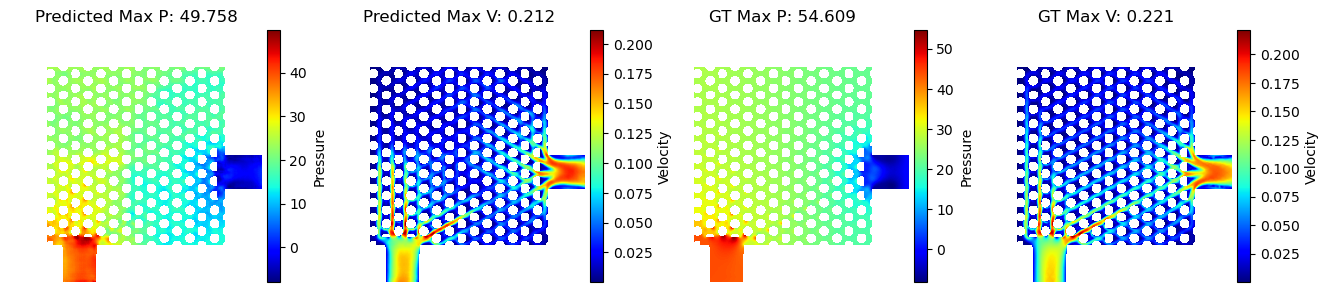

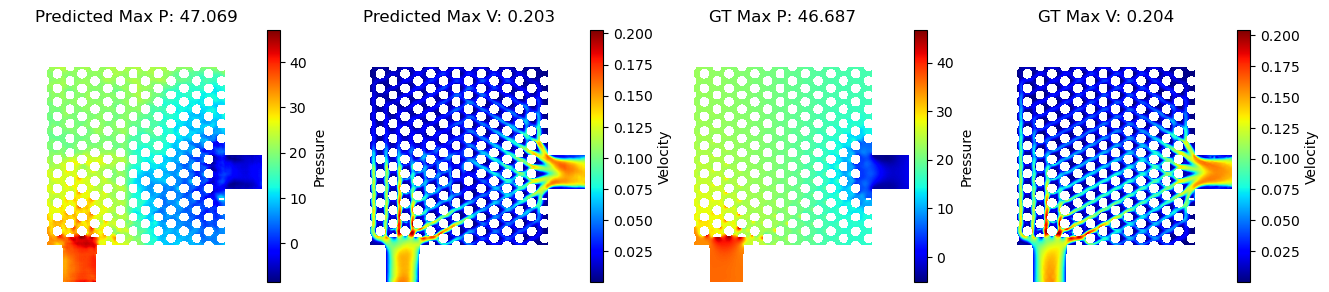

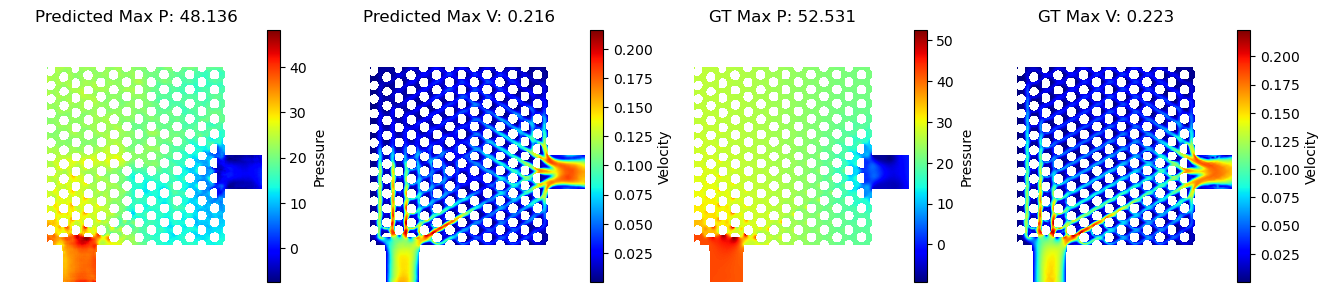

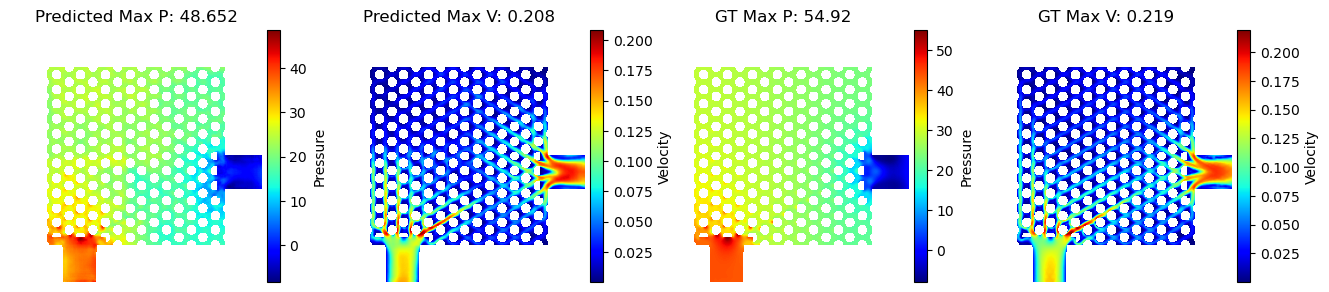

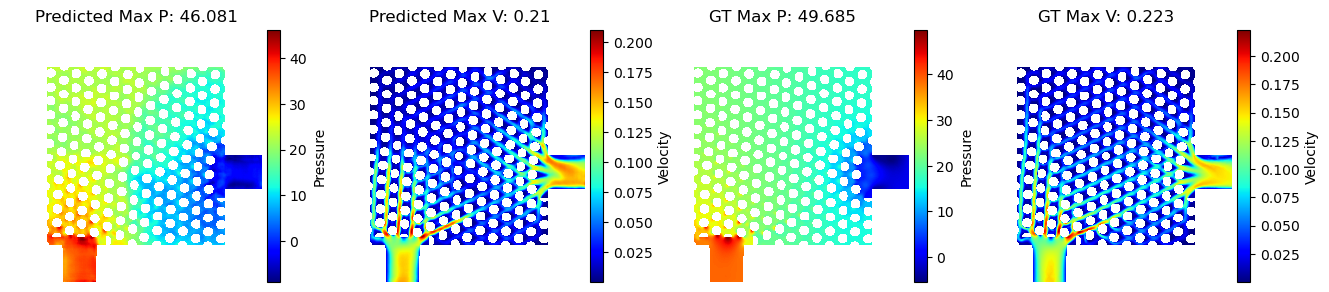

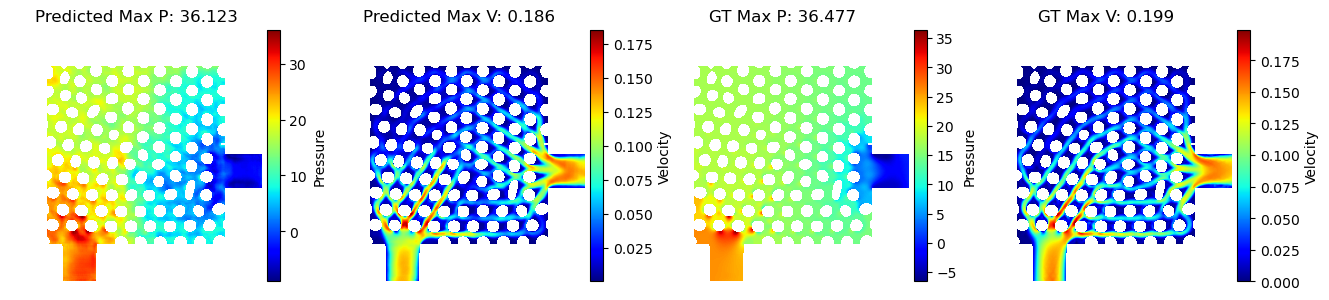

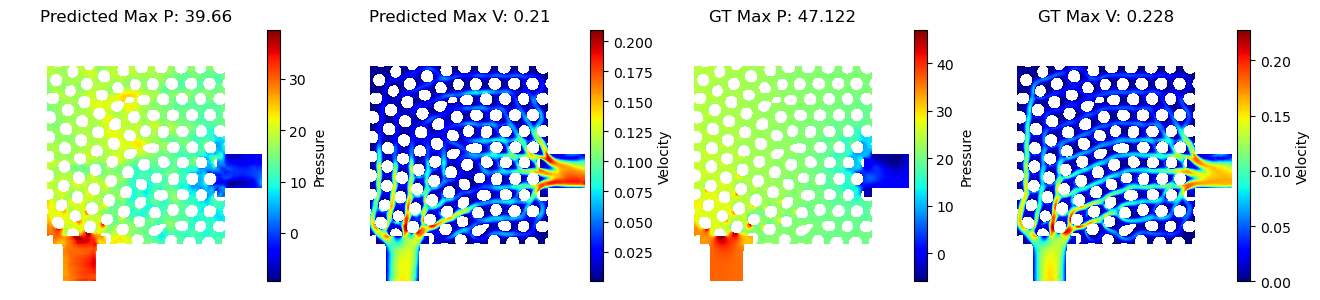

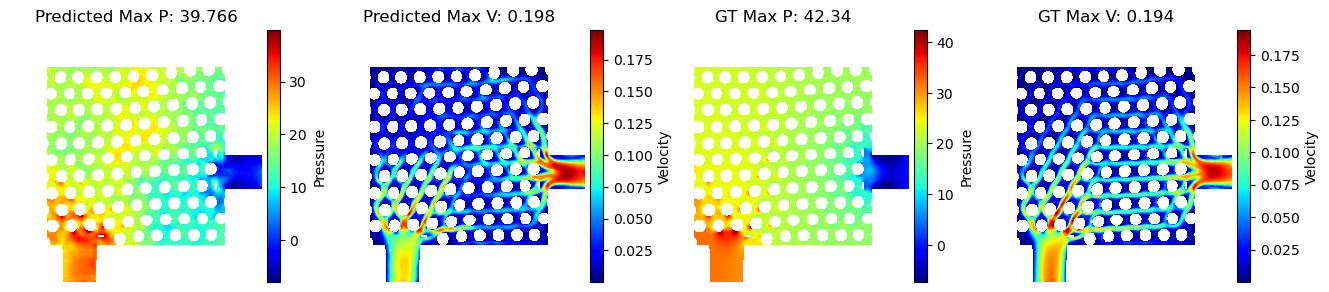

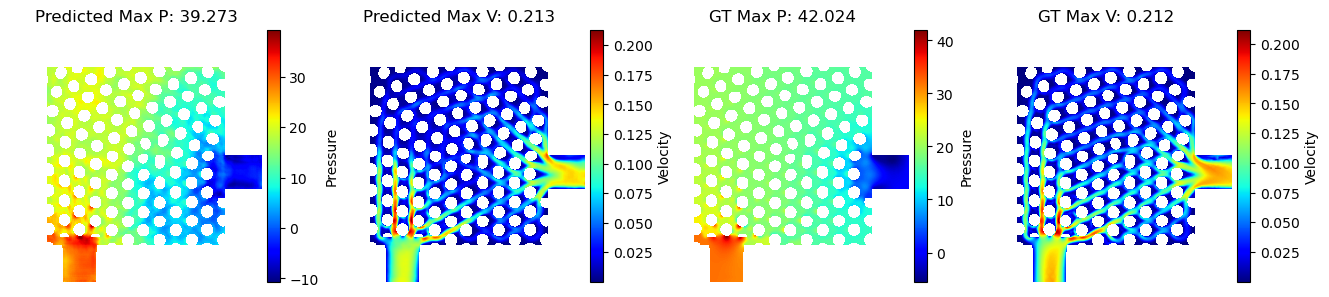

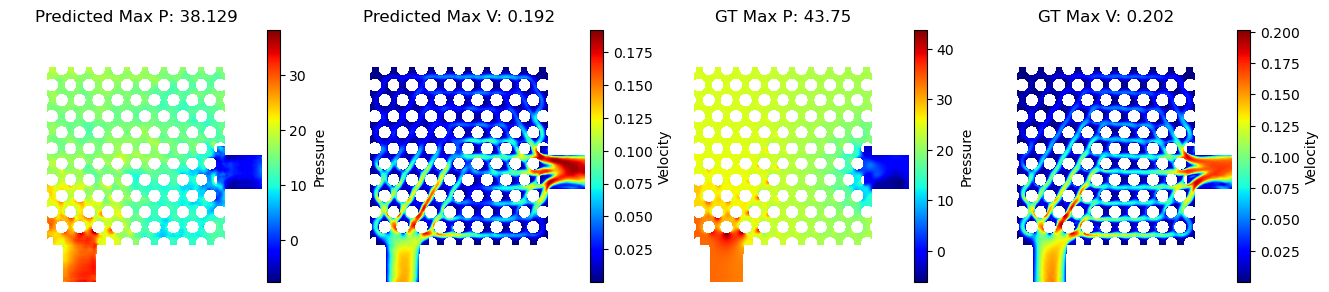

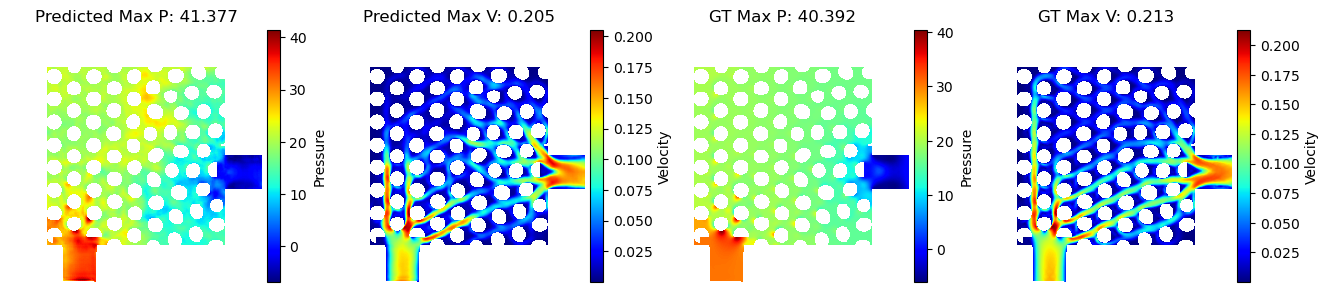

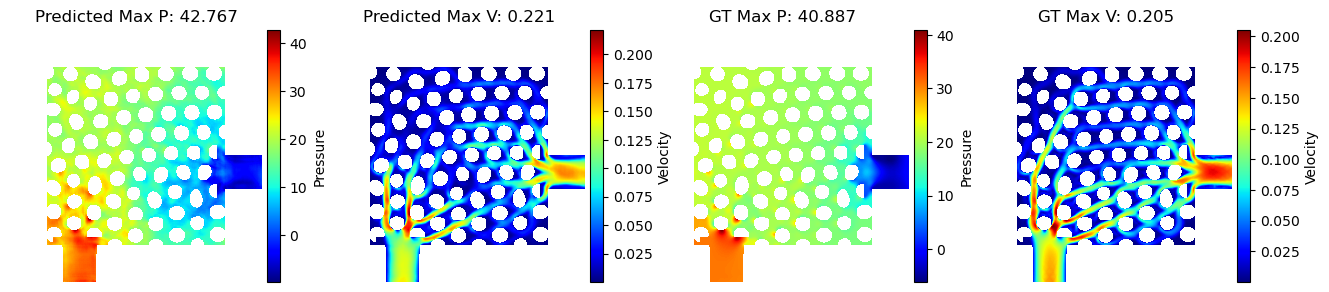

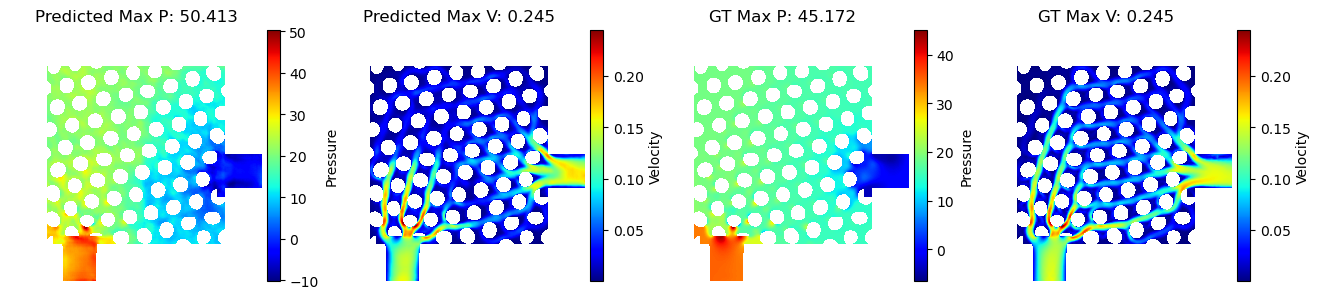

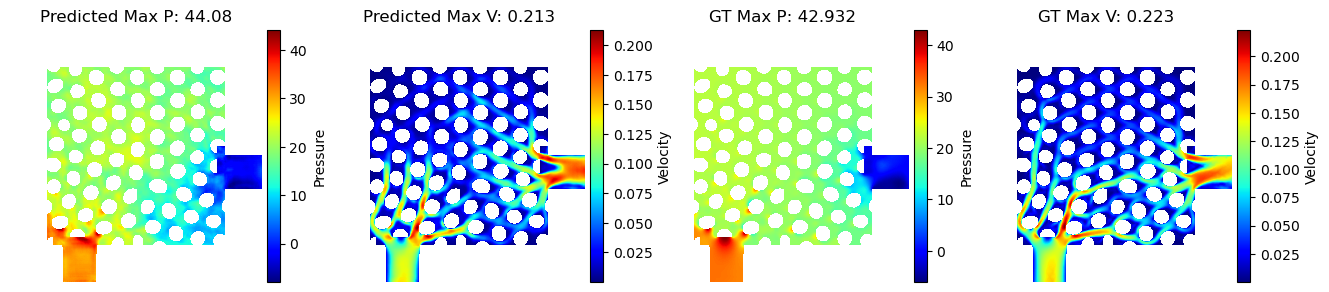

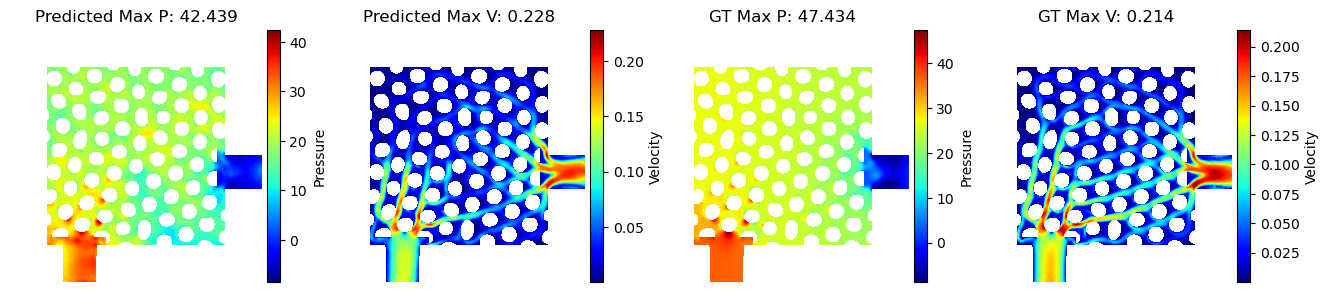

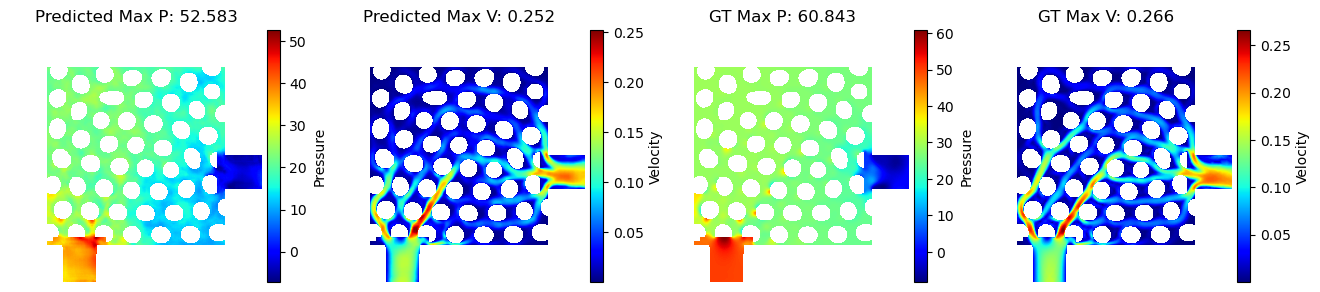

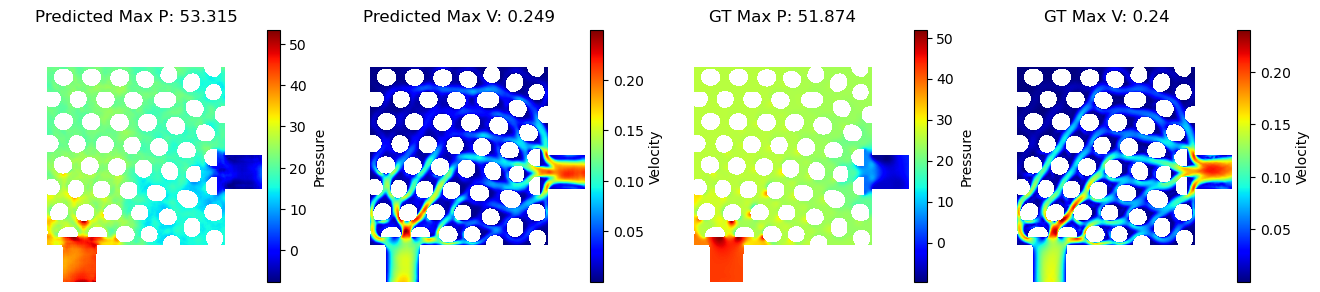

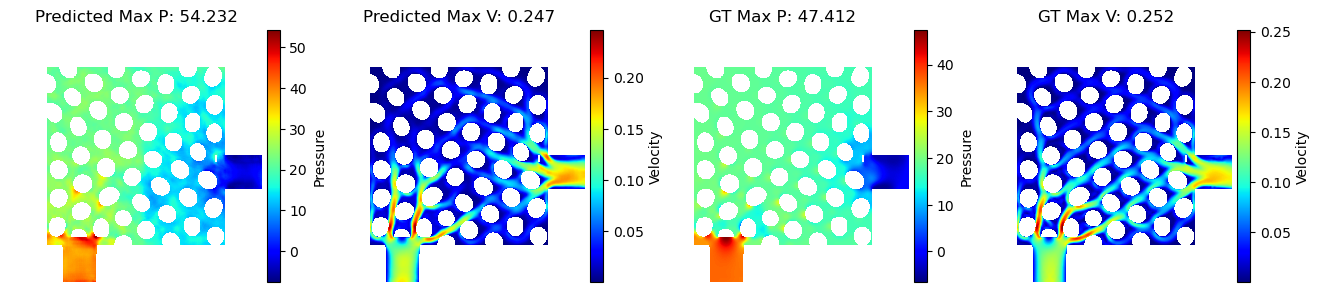

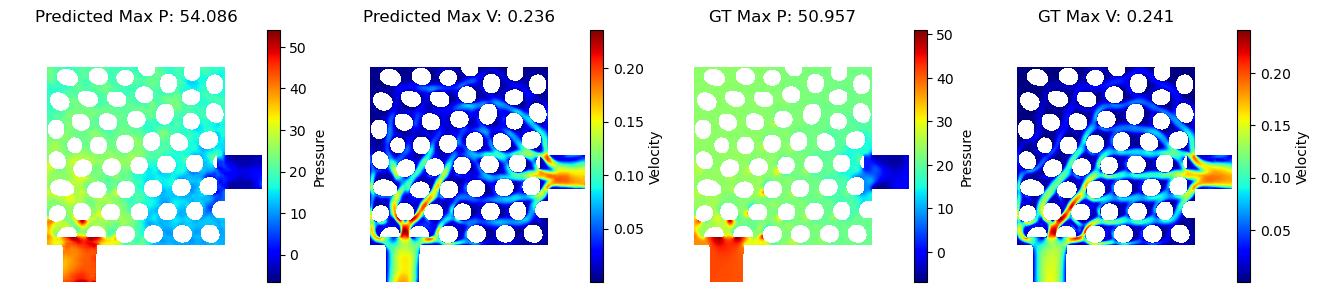

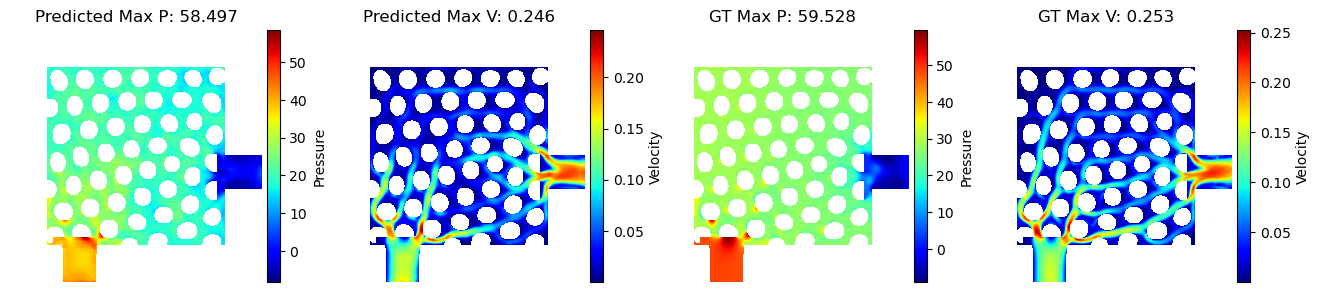

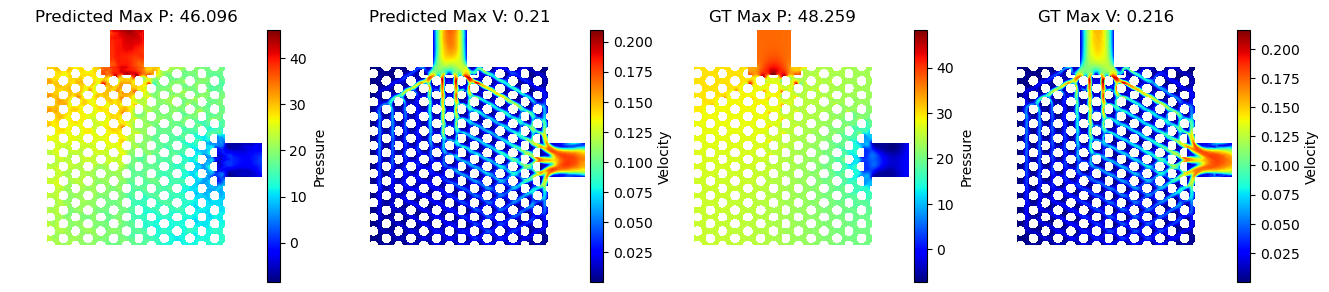

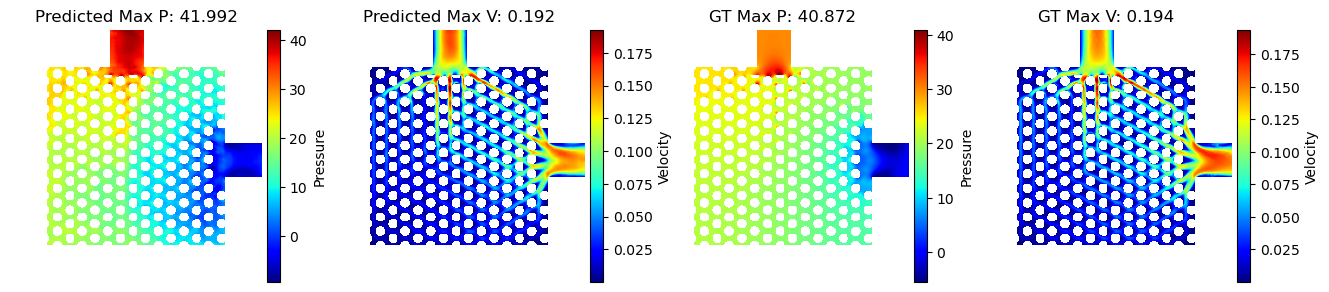

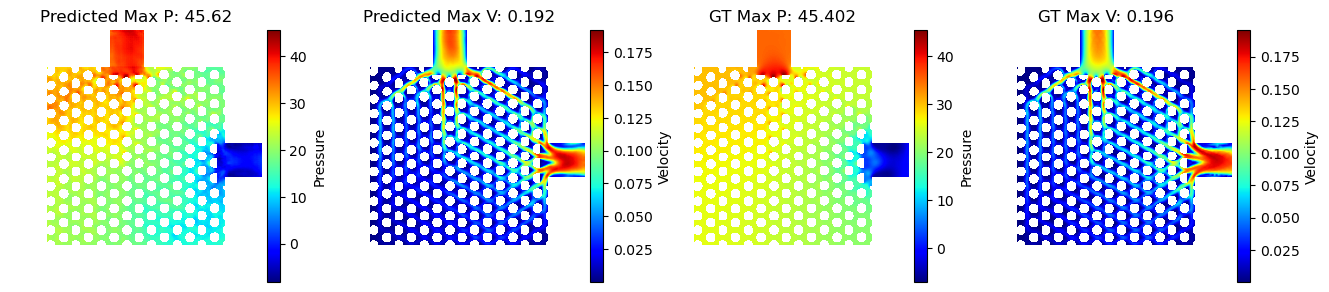

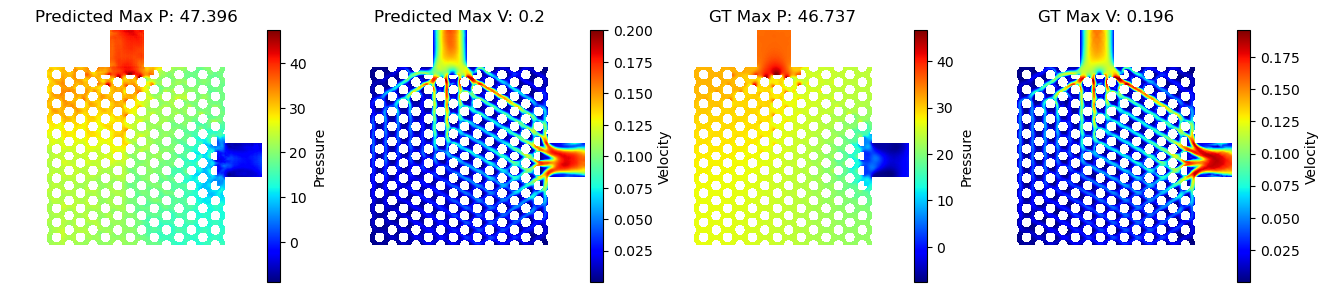

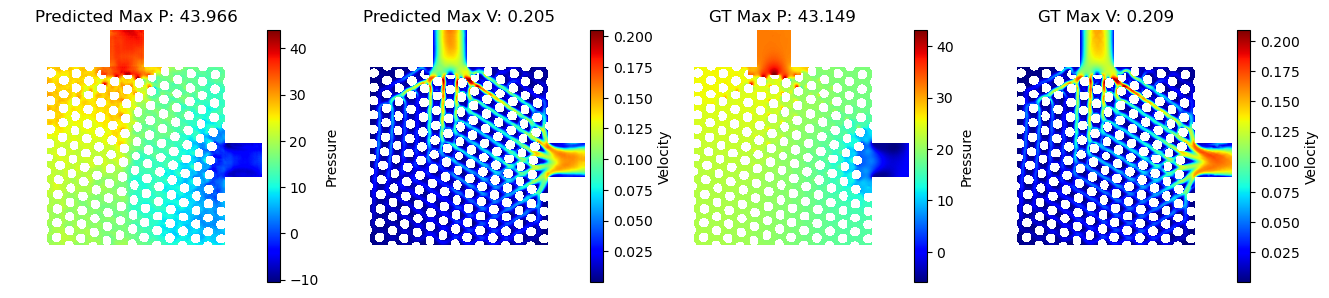

In [2]:
import matplotlib.pyplot as plt



hv2_folder = 'Validation/High/HVV'
hp2_folder = 'Validation/High/HPP'
lg2_folder = 'Validation/LG-3C2'

# Get the list of file names in each folder

hv2_files = [f2 for f2 in os.listdir(hv2_folder) if f2 != ".ipynb_checkpoints"]
hp2_files = [f2 for f2 in os.listdir(hp2_folder) if f2 != ".ipynb_checkpoints"]
lg2_files = [f2 for f2 in os.listdir(lg2_folder) if f2 != ".ipynb_checkpoints"]

# Sort the file names to ensure the order is consistent
hv2_files.sort()
hp2_files.sort()
lg2_files.sort()


# Set the input shape
input_shape = (256, 256, 3)  # Update to 3 channels for color images

# Create empty lists to store the data
X_lg2 = []
Y_hv2 = []
Y_hp2 = []

# Read the data from the folders
for hv2_file,hp2_file,lg2_file in zip( hv2_files,hp2_files,lg2_files):
    try:
        
        

        # Read the HFV
        hv2_image = np.load(os.path.join(hv2_folder, hv2_file))  # Convert to RGB
        Y_hv2.append(np.array(hv2_image))

    
    
        # Read the channel geometry image
        lg2_image = Image.open(os.path.join(lg2_folder, lg2_file)).convert('RGB')  # Convert to RGB
        lg2_image = lg2_image.resize(input_shape[:2])  # Resize the image
        X_lg2.append(np.array(lg2_image))
    
        # Read the HFP
        hp2_image = np.load(os.path.join(hp2_folder, hp2_file))  # Convert to RGB
        Y_hp2.append(np.array(hp2_image))
    except:
        print('')

# Convert the lists to arrays


X_lg2 = np.array(X_lg2) / 255.0  # Normalize the channel geometry images
Y_hv2 = np.array(Y_hv2)
Y_hp2 = np.array(Y_hp2)



model.load_weights('Saved_Models_Temp/Micro-Unet-Zero-new.h5')

pressure_output2,velocity_output2 = model.predict([X_lg2])

velocity_output2=(velocity_output2)
a=(np.max(Y_hp)-np.min(Y_hp))
b=(np.min(Y_hp))

pressure_output2=(pressure_output2*a)+b



mask = np.all(X_lg2 > 0.8, axis=-1)

# Expand mask to match the shape of array2
mask_expanded = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
Y_hp2[mask]=np.nan
Y_hv2[mask]=np.nan
velocity_output2[mask]=np.nan
pressure_output2[mask]=np.nan

from mpl_toolkits.axes_grid1 import make_axes_locatable






def plot_images(index):
    plt.figure(figsize=(16, 48))

    # Display the pressure output
    ax1 = plt.subplot(1, 4, 1)
    im1 = ax1.imshow(pressure_output2[index],cmap='jet')
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1, label='Pressure')
    ax1.set_title('Predicted Max P: '+ str(np.round(np.nanmax(pressure_output2[index]),decimals=3)))
    ax1.axis("off")

    # Display the velocity output
    ax2 = plt.subplot(1, 4, 2)
    im2 = ax2.imshow(velocity_output2[index],cmap='jet')
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2, label='Velocity')
    ax2.set_title('Predicted Max V: '+ str(np.round(np.nanmax(velocity_output2[index]),decimals=3)))
    ax2.axis("off")

    # Display the input image (Pressure GT)
    ax3 = plt.subplot(1, 4, 3)
    im3 = ax3.imshow(Y_hp2[index],cmap='jet')
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax3, label='Pressure')
    ax3.set_title('GT Max P: '+ str(np.round(np.nanmax(Y_hp2[index]),decimals=3)))
    ax3.axis("off")

    # Display the velocity GT
    ax4 = plt.subplot(1, 4, 4)
    im4 = ax4.imshow(Y_hv2[index],cmap='jet')
    divider4 = make_axes_locatable(ax4)
    cax4 = divider4.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im4, cax=cax4, label='Velocity')
    ax4.set_title('GT Max V: '+ str(np.round(np.nanmax(Y_hv2[index]),decimals=3)))
    ax4.axis("off")

    plt.show()

# Loop to plot images 
for i in range(0, 25):
    plot_images(i)

In [5]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

Yp = np.expand_dims(Y_hp2, axis=-1)
Yv = np.expand_dims(Y_hv2, axis=-1)

expected = Yp
predicted = pressure_output2

# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"Relative Error: {re:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")



MSE: 199.0996
MAE: 8.5694
RMSE: 14.1103
R^2: 0.6455
NRMSE: 0.0245
Relative Error: 4.0449
SMAPE: 75.8900%
Pearson Correlation: 0.8618
PSNR: 31.3183 dB


In [6]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Dummy data (replace with actual predicted and expected arrays)
expected = Yv
predicted = velocity_output2

# Mean Squared Error (MSE)
mse = np.nanmean((expected - predicted) ** 2)

# Mean Absolute Error (MAE)
mae = np.nanmean(np.abs(expected - predicted))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Coefficient of Determination (R^2)
ss_tot = np.nanmean((expected - np.nanmean(expected)) ** 2)
ss_res = np.nanmean((expected - predicted) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Normalized Root Mean Squared Error (NRMSE)
nrmse = rmse / (np.nanmax(expected) - np.nanmin(expected))

# Relative Error (RE)
relative_error = np.abs(expected - predicted) / np.abs(expected)
re = np.nanmean(relative_error)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = 100 * np.nanmean(2 * np.abs(expected - predicted) / (np.abs(expected) + np.abs(predicted)))

# Pearson Correlation Coefficient (r)
expected_flattened = expected.flatten()
predicted_flattened = predicted.flatten()
valid_mask = ~np.isnan(expected_flattened) & ~np.isnan(predicted_flattened)
expected_valid = expected_flattened[valid_mask]
predicted_valid = predicted_flattened[valid_mask]
pearson_corr = np.corrcoef(expected_valid, predicted_valid)[0, 1]



# Peak Signal-to-Noise Ratio (PSNR)
psnr = 10 * np.log10(np.nanmax(expected) ** 2 / mse)

# Print Results
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"Relative Error: {re:.4f}")
print(f"SMAPE: {smape:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"PSNR: {psnr:.4f} dB")



MSE: 0.00046211
MAE: 0.0126
RMSE: 0.0215
R^2: 0.8468
NRMSE: 0.0236
Relative Error: 304439758.5402
SMAPE: 53.5119%
Pearson Correlation: 0.9205
PSNR: 32.5534 dB


In [7]:
path1="Results_Temp/Physics/Zero-Fidelity"
os.makedirs(path1, exist_ok=True)
np.save(path1+"/velocity_predicted.npy",velocity_output2)
np.save(path1+"/pressure_predicted.npy",pressure_output2)
